In [16]:
import numpy as np
import pandas as pd
import uproot as up
import histlite as hl

import os

import time

import matplotlib.patches as patch
from matplotlib.collections import PatchCollection

from matplotlib import pyplot as plt

import time


plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 18})

In [17]:
# Energy, intensity
ba133_list = [ [30.635, 0.339],
              [30.972, 0.622],
              [34.92, 0.0588],
              [34.987, 0.114],
              [35.818, 0.0351],
              [53.1622, 0.0214],
               [79.6124, 0.0265],
               [80.9979, 0.329],
               [160.612, 0.00638],
               [223.2368, 0.00453],
               [276.3989, 0.0716],
               [302.8502, 0.1834],
               [356.0129, 0.6205],
               [383.8485, 0.0894]]

co60_list = [[1173.228, 0.9985],
             [1332.492, 0.999826] ]

cs137_list = [[31.817, 0.0199],
              [32.194, 0.0364],
              [36.304, 0.00348],
              [36.378, 0.00672],
              [37.255, 0.00213],
              [283.5, 0.0000058],
              [661.657, 0.8510]]

cs136_list = [[31.817, 0.0386],
             [32.194, 0.0704],
             [36.304, 0.00674],
             [36.378, 0.0130],
             [37.255,0.00411],
             [66.881, 0.0479],
             [86.36,0.059],
             [153.246, 0.077],
             [163.92, 0.0469],
             [176.602, 0.137],
             [273.646, 0.1266],
             [340.547, 0.468],
             [818.514, 0.997],
             [1048.073, 0.8],
             [1235.362, 0.2]]
#             [507.188, 0.01],

tl208_list = [[2614.511, 0.99754]]

k40_list = [[1460.820, 0.1066]]

annihil_list = [[510.99895, 1.0]]

def GenArrayFromList( thislist ):
    templist = [np.array(sublist) for sublist in thislist]
    return np.array(templist)


ba133 = GenArrayFromList( ba133_list )
co60 = GenArrayFromList( co60_list )
cs137 = GenArrayFromList( cs137_list )
cs136 = GenArrayFromList( cs136_list )
tl208 = GenArrayFromList( tl208_list )
k40 = GenArrayFromList( k40_list )
annihil = GenArrayFromList( annihil_list )

isotopes_dict = {'ba133': ba133,
                'co60': co60,
                'cs137': cs137,
                'cs136': cs136,
                'tl208': tl208,
                'k40': k40,
                'annihil': annihil}

               

# Rough calibration functions

In [18]:
# Calibration constants given in terms of slope/intercept
ge_ecal_scott = [[0.01008591,0.31],
            [0.0105275,2.03], 
            [0.04566925,-0.58],
            [0.0456691, - 0.87]]

ge_ecal_me = [ np.array([0.94837024, 0.26117983]), 
                 np.array([1.03879621, 1.91241092]), 
                 np.array([ 0.96422411, -1.21903083]), 
                 np.array([ 0.99974226, -0.87967122])]

ge_tcal = [-184.1,
           -202.1,
           -151.9,
           -190.5]

ns_per_ch = 0.09765

ge_channels = [0,2,4,6]


#####################################################################
def ApplyRoughECalibrationGe( scp_amplitude, ch ):
    
    scp_amplitude = np.copy( scp_amplitude )
    
    tmp_energy = ge_ecal_scott[ch][0] * scp_amplitude + \
                                ge_ecal_scott[ch][1]
    calibrated_ge_energy = (tmp_energy - ge_ecal_me[ch][1]) / \
                                ge_ecal_me[ch][0]
    
    return calibrated_ge_energy


#####################################################################
def GaussianWLinearBkg( x, A, mu, sig, a, b):
    return A/np.sqrt(2*np.pi*sig**2)*np.exp(-(x-mu)**2/(2*sig**2)) + \
            a*x + b


from scipy.optimize import curve_fit
#####################################################################
def FitSinglePeak( hist, fitrange=None, p0=None ):
    bin_centers = (hist.bins[0][1:] + hist.bins[0][:-1])/2.
    bin_vals = hist.values
    
    mask = np.ones(len(bin_vals), dtype=bool)
    if fitrange is not None:
        mask = (bin_centers > fitrange[0]) & (bin_centers < fitrange[1])
        
    xfit = bin_centers[mask]
    yfit = bin_vals[mask]
    
    if p0 is None:
        A_guess = np.max(yfit) * np.sqrt(2*np.pi*100)
        mu_guess = xfit[np.where(yfit==np.max(yfit))[0]][0]
        sig_guess = 10.
        a_guess = 0.
        b_guess = np.mean(yfit[0:3])
        
        p0 = [A_guess, mu_guess, sig_guess, a_guess, b_guess]
        
#     print(p0)
#     print(xfit)
#     print(yfit)
    try:
        if np.sum((yfit==0.)) == 0:
            p, pcov = curve_fit(GaussianWLinearBkg, xfit, yfit, \
                            sigma=np.sqrt(yfit),\
                           p0=p0)
        else:
            p, pcov = curve_fit(GaussianWLinearBkg, xfit, yfit, \
                           p0=p0)
    except:
        print('Unable to fit.')
        
        p = np.array(p0)
        pcov = np.zeros((len(p0), len(p0)))
    
    
    return p, pcov, xfit, yfit

#####################################################################
def Line(x, a, b):
    return a*x + b

#####################################################################
def Quadratic( x, a, b, c):
    return a*x**2 + b*x + c

#####################################################################
def QuadraticBetter( x, a, b, c):
    return (a*x-b)**2 + c

#####################################################################
def InverseQuadratic( ADC, a, b, c):
    numerator = ADC + b**2/(4*a) - c
    return np.sqrt(numerator/a) - b/(2*a)

#####################################################################
def PowerLaw( x, a, b, c):
    return a*x**b + c

#####################################################################
def LinFit(data, p0=None):
    
    if p0 is None:
        p0 = [ data[-1,1]/data[-1,0], 0.]
    
    p, pcov = curve_fit( Line, data[:,0], data[:,1], \
                        sigma=data[:,2], p0=p0  )
    
    return p, pcov

#####################################################################
def QuadFit(data, p0=None):
    
    if p0 is None:
        p0 = [ 0., data[-1,1]/data[-1,0], 0.]
    print(p0)
    
    p, pcov = curve_fit( Quadratic, data[:,0], data[:,1], \
                        sigma=data[:,2], p0=p0  )
    return p, pcov


#####################################################################
def PowerLawFit(data, p0=None):
    
    if p0 is None:
        p0 = [ 1., -0.5, 0.]
    
    p, pcov = curve_fit( PowerLaw, data[:,0], data[:,1], \
                        sigma=data[:,2], p0=p0  )
    return p, pcov
    


# Ge6 calibrations with 133Ba

Using Run199, which has 136Cs and 133Ba on Ge4 and Ge6

In [19]:
fname199 = 'root_data_Xe136_run199.bin_tree.root'
datapath = '/p/lustre1/lenardo1/tunl_cs136_data/'

detectors = ['ge0', 'ge2', 'ge4', 'ge6']

def GetDataDict( filename ):
    print('Opening file...')
    tree = up.open(filename)['Xe136']
    raw_data = tree.arrays(library='np')
    #print(raw_data.keys())

    datadict = {}
    
    for i in range(4):
        print('\t{}'.format(detectors[i]))
        subdict = {}
        subdict['raw energy'] = raw_data['scp_amplitude'][:,2*i]
        subdict['rough energy'] = ApplyRoughECalibrationGe(\
                                subdict['raw energy'], \
                                i )
        subdict['raw tof'] = ( np.copy(raw_data['scp_time'][:,2*i]) - \
                             np.copy(raw_data['scp_pickoff'][:,0]) ) * ns_per_ch
        subdict['rough tof'] = subdict['raw tof'] - ge_tcal[i]
        subdict['pileup'] = np.copy( raw_data['scp_pileup'][:,2*i] )
        
        datadict[detectors[i]] = subdict
        

    return datadict



In [20]:
run199 = GetDataDict( datapath + fname199 )

Opening file...
	ge0
	ge2
	ge4
	ge6


[1732.35699028 4819.21557811 6644.07904859 ... 1788.45731688 2887.93653886
 2457.05132893]


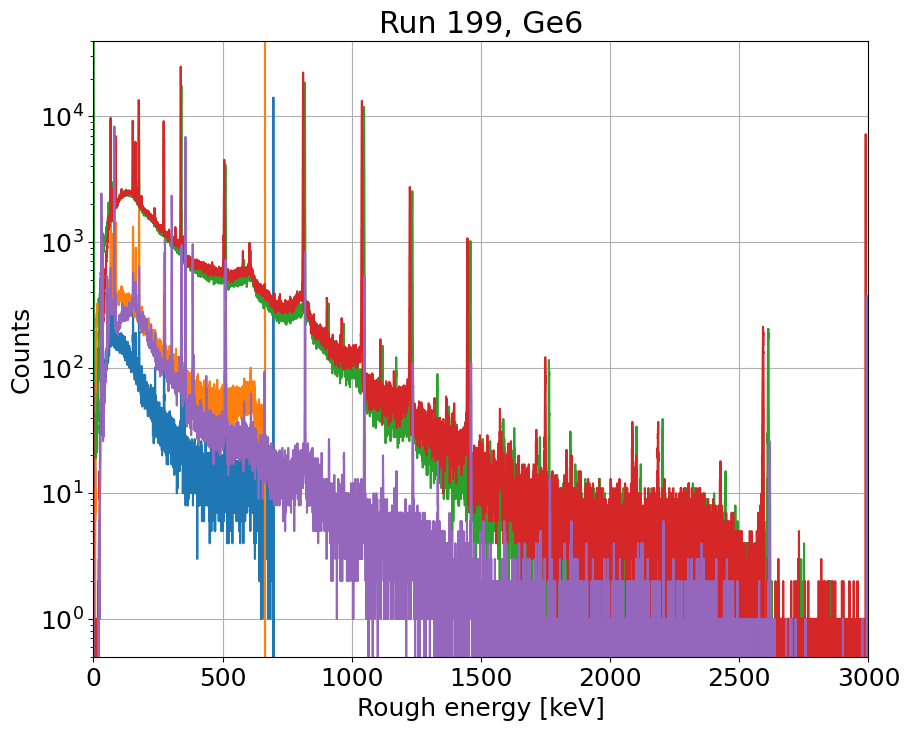

In [21]:
det = 'ge6'

mask = (run199[det]['pileup'] < 1.)

print(run199[det]['raw energy'][mask])

h_ge0_199 = hl.hist( run199[det]['rough energy'][mask],\
                   bins=np.linspace(0.,3000.,8000))
hl.plot1d(h_ge0_199)

# det = 'ge6'
# h_ge6_197 = hl.hist( run197[det]['rough energy'][mask],\
#                    bins = np.linspace(0.,2000.,1000))
#hl.plot1d(h_ge6_197)
plt.xlim(0.,3000.)
plt.yscale('log')
plt.xlabel('Rough energy [keV]')
plt.ylabel('Counts')
plt.title('Run 199, Ge6')
plt.grid()
plt.show()

In [22]:
plt.rcParams['figure.figsize'] = [7,4]
plt.rcParams.update({'font.size': 14})

valid_isotopes = ['ba133', 'cs136', 'k40', 'tl208']
det = 'ge6'
plot=False

e_thresh = 40.
intensity_thresh = 0.01
all_lines = np.concatenate([isotopes_dict[iso][:,0] for iso in valid_isotopes])
all_intensities = np.concatenate([isotopes_dict[iso][:,1] for iso in valid_isotopes])
mask = (all_lines > e_thresh) & (all_intensities > intensity_thresh)
fit_lines = all_lines[mask]

fit_lines.sort()

# print(fit_lines)

efit = []
sigfit = []

for i,line in enumerate(fit_lines):
    
    line_diffs = np.abs(fit_lines - line)
    if np.sum(line_diffs < 3.) > 1:
        print('Line at {:5.5} keV is too close to another line'.format(line) +\
             ' to fit reliably.')
        continue
    
    print('Fitting line at {:5.5} keV...'.format(line))
    
    
    mask = (run199[det]['rough energy'] > line*0.97) & \
            (run199[det]['rough energy'] < line*1.03) & \
            (run199[det]['pileup'] < 1.)
    
    data = run199[det]['raw energy'][mask]
    
    hfit = hl.hist( data, \
                   bins=np.linspace(np.min(data), np.max(data),100))
    

    p, pcov, xfit, yfit = FitSinglePeak(hfit)
#     print(p)
    
    efit.append( np.array([line, p[1], np.sqrt(pcov[1,1])]) )
    sigfit.append( np.array( [line, p[2], np.sqrt(pcov[2,2])]) )
    
    
    if plot:
        plt.figure(i)

        plt.title('{}, fit to line at {:5.5} keV'.format(det,line))
        plt.xlabel('Energy [ADC]')
        plt.ylabel('Counts')
        plt.errorbar(xfit,yfit,yerr=np.sqrt(yfit), fmt='o')
        xcurve = np.linspace(xfit[0],xfit[-1],200)
        ycurve = GaussianWLinearBkg(xcurve, *p)
        plt.plot(xcurve,ycurve,'-r')
        plt.show()

efit = np.array(efit)
sigfit = np.array(sigfit)



Fitting line at 53.162 keV...
Fitting line at 66.881 keV...
Line at 79.612 keV is too close to another line to fit reliably.
Line at 80.998 keV is too close to another line to fit reliably.
Fitting line at 86.36 keV...
Fitting line at 153.25 keV...
Fitting line at 163.92 keV...
Fitting line at 176.6 keV...
Line at 273.65 keV is too close to another line to fit reliably.
Line at 276.4 keV is too close to another line to fit reliably.
Fitting line at 302.85 keV...
Fitting line at 340.55 keV...
Fitting line at 356.01 keV...
Fitting line at 383.85 keV...
Fitting line at 818.51 keV...
Fitting line at 1048.1 keV...
Fitting line at 1235.4 keV...
Fitting line at 1460.8 keV...
Fitting line at 2614.5 keV...


In [23]:
# plt.rcParams['figure.figsize'] = [10,8]
# plt.rcParams.update({'font.size': 18})



# plt.errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

# plt.xlabel('True energy [keV]')
# plt.ylabel('Fitted ADC')
# plt.title('{} energy calibration'.format(det))
# plt.xlim(0.,3000.)
# plt.ylim(0.,65000.)
# plt.grid()

# # plt.xscale('log')
# # plt.yscale('log')
# # plt.xlim(10.,3000.)
# # plt.ylim(100.,65000.)

# plt.show()

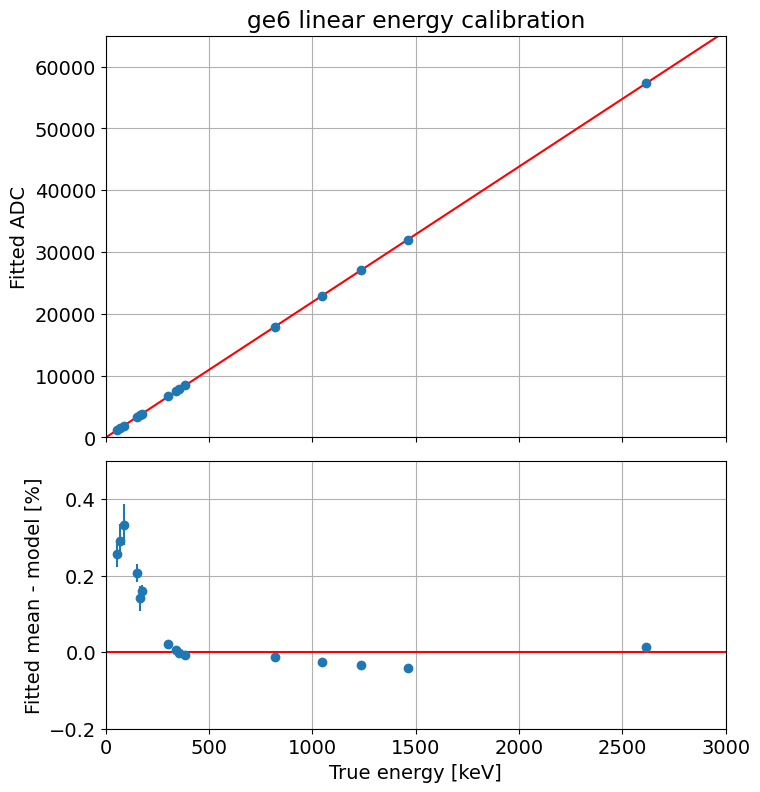

In [24]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 2],\
                                   'hspace':0.07})

p, pcov = LinFit( efit )

# ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

xfit = np.linspace(0.,3000.,200)
yfit = Line(xfit, *p)

ax[0].plot(xfit, yfit, '-r')
ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

residuals = efit[:,1] - Line(efit[:,0], *p)

ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/Line(efit[:,0], *p)*100, \
               yerr=efit[:,2]/Line(efit[:,0], *p)*100, \
               fmt='o')
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-0.2, 0.5)

ax[1].set_xlabel('True energy [keV]')
ax[0].set_ylabel('Fitted ADC')
ax[0].set_title('{} linear energy calibration'.format(det))
ax[0].set_xlim(0.,3000.)
ax[0].set_ylim(0.,65000.)
ax[0].grid()
ax[1].grid()


# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10.,3000.)
# plt.ylim(100.,65000.)

plt.show()

[0.0, 21.91820408108412, 0.0]
[9.12338970e-06 2.18929781e+01 2.82000732e+00]


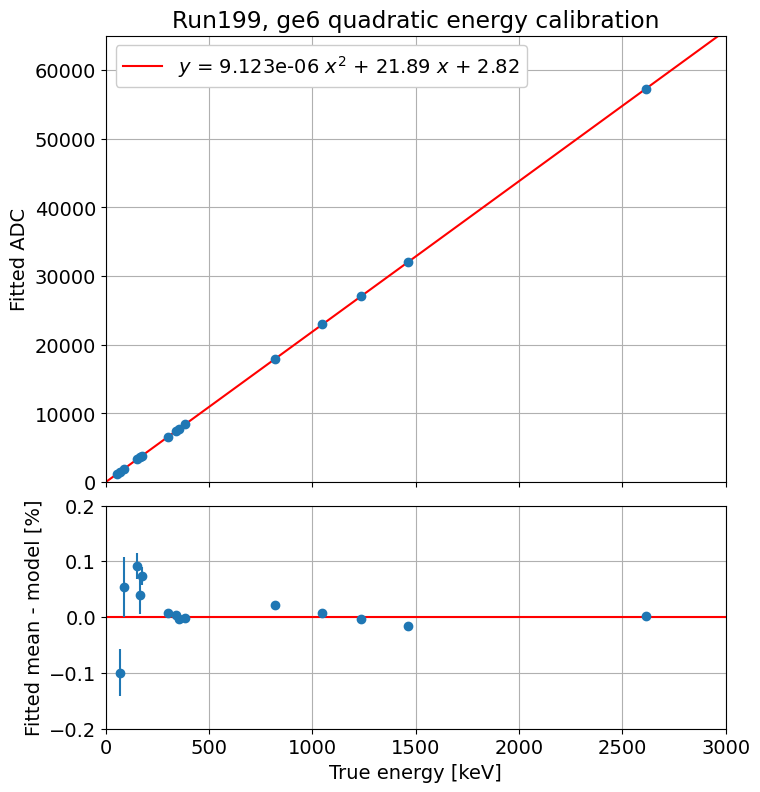

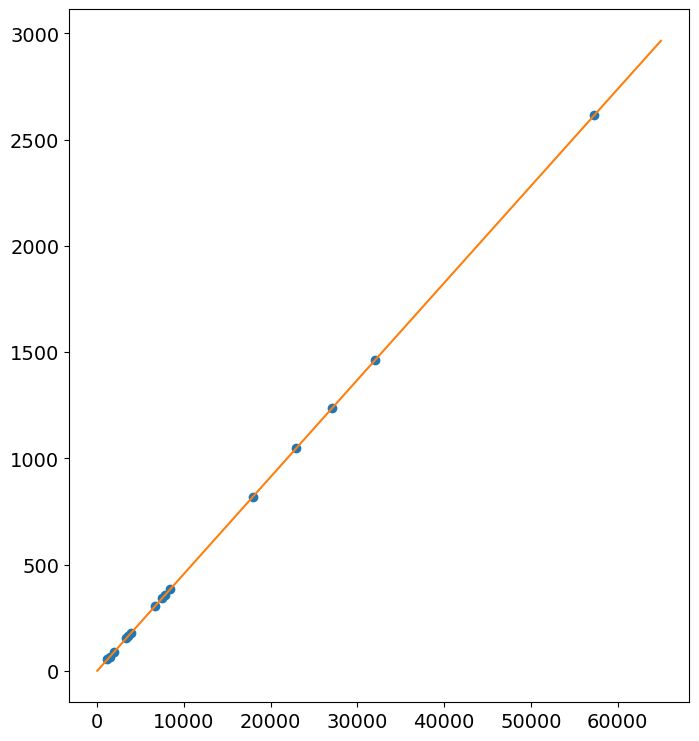

In [25]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})


p, pcov = QuadFit( efit[:] )

# ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

xfit = np.linspace(0.,3000.,200)
yfit = Quadratic(xfit, *p)

ax[0].plot(xfit, yfit, '-r',\
          label='$y$ = {:4.4} $x^2$ + {:4.4} $x$ + {:4.4}'.format(p[0], p[1], p[2]))
ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

residuals = efit[:,1] - Quadratic(efit[:,0], *p)

print(p)

ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/Quadratic(efit[:,0], *p)*100, \
               yerr=efit[:,2]/Quadratic(efit[:,0], *p)*100, \
               fmt='o')
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-0.2, 0.2)

ax[0].legend(framealpha=1.)

ax[1].set_xlabel('True energy [keV]')
ax[0].set_ylabel('Fitted ADC')
ax[0].set_title('Run199, {} quadratic energy calibration'.format(det))
ax[0].set_xlim(0.,3000.)
ax[0].set_ylim(0.,65000.)
ax[0].grid()
ax[1].grid()

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10.,3000.)
# plt.ylim(100.,65000.)
plt.savefig('energy_cal_plots/run199_ge6_quadratic_energy_calibration.png',\
           dpi=300, bbox_inches='tight')

plt.show()


plt.figure(2)

plt.plot(efit[:,1], efit[:,0], 'o')
xguess = np.linspace(0.,65000.,200)
yguess = InverseQuadratic( xguess, *p)
plt.plot(xguess,yguess)
plt.show()


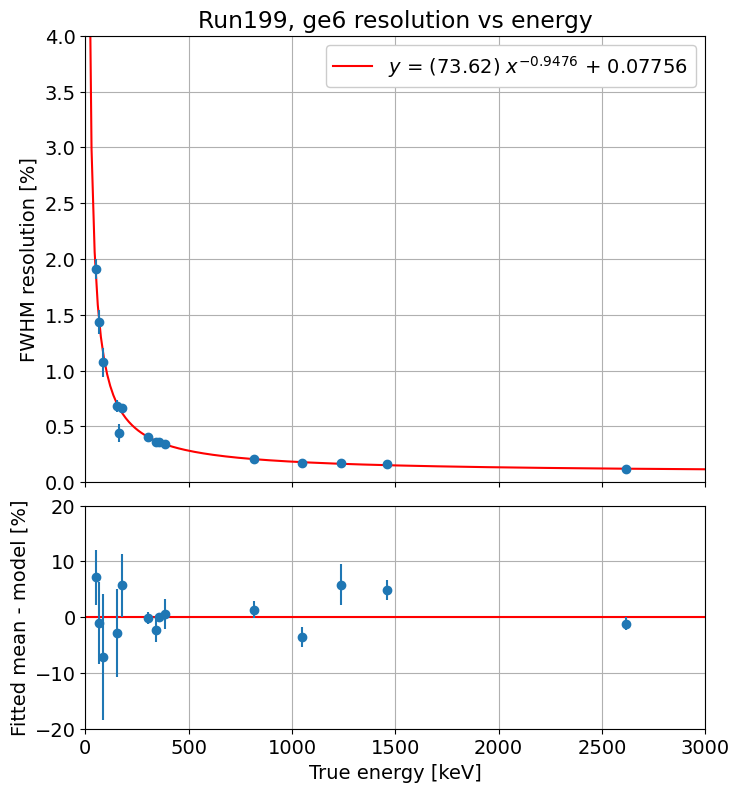

In [26]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})
resolution = sigfit[:,1] / efit[:,1] * 100 * 2.355
resolution_unc = resolution * np.sqrt( (efit[:,2]/efit[:,1])**2 + \
                                      (sigfit[:,2]/sigfit[:,1])**2 )
array_data = np.vstack([sigfit[:,0], resolution, resolution_unc])
p, pcov = PowerLawFit( array_data.T  )
xfit = np.linspace(0.1,3000.,200)
yfit = PowerLaw( xfit, *p)
ax[0].plot(xfit,yfit,'-r',\
          label='$y$ = ({:4.4}) $x^{{{:4.4}}}$ + {:4.4}'.format(p[0],p[1],p[2]))
ax[0].set_title('Run199, {} resolution vs energy'.format(det))

ax[0].errorbar( sigfit[:,0], resolution, yerr = resolution_unc, fmt='o')


ax[1].set_xlabel('True energy [keV]')

ax[0].set_ylabel('FWHM resolution [%]')
ax[0].grid()
ax[0].set_xlim(0.,3000.)
ax[0].set_ylim(0.,4.0)


ax[0].legend(framealpha=1.)

residuals = resolution - PowerLaw(sigfit[:,0], *p)
ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/PowerLaw(sigfit[:,0], *p)*100, \
               yerr=resolution_unc/PowerLaw(sigfit[:,0], *p)*100, \
               fmt='o')
ax[1].grid()
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-20, 20)

plt.savefig('energy_cal_plots/run199_ge6_power_law_resolution_fit_lin.png',\
           dpi=300, bbox_inches='tight')

plt.show()

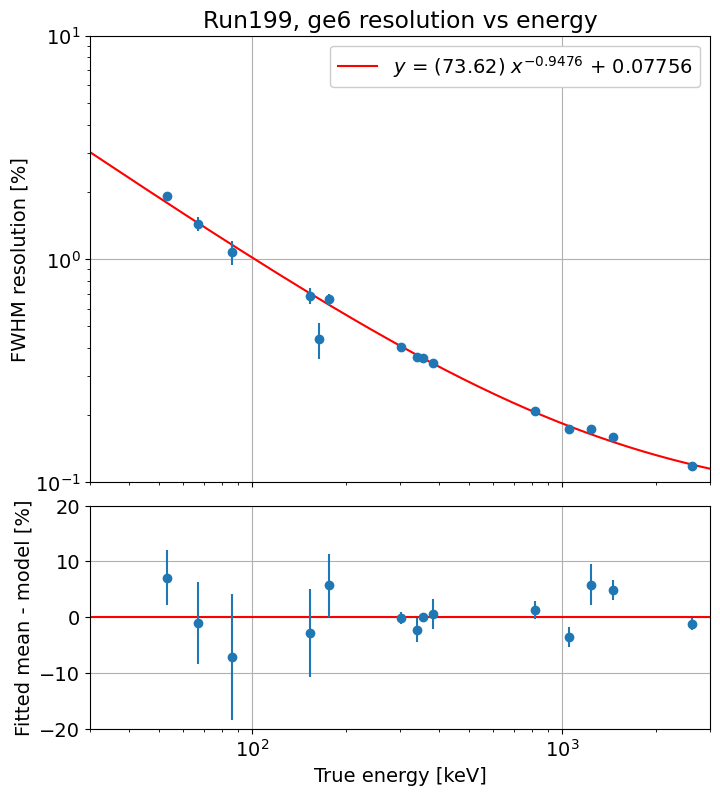

In [27]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})
resolution = sigfit[:,1] / efit[:,1] * 100 * 2.355
resolution_unc = resolution * np.sqrt( (efit[:,2]/efit[:,1])**2 + \
                                      (sigfit[:,2]/sigfit[:,1])**2 )
array_data = np.vstack([sigfit[:,0], resolution, resolution_unc])
p, pcov = PowerLawFit( array_data.T  )
xfit = np.linspace(0.1,3000.,200)
yfit = PowerLaw( xfit, *p)
ax[0].plot(xfit,yfit,'-r',\
          label='$y$ = ({:4.4}) $x^{{{:4.4}}}$ + {:4.4}'.format(p[0],p[1],p[2]))
ax[0].set_title('Run199, {} resolution vs energy'.format(det))

ax[0].errorbar( sigfit[:,0], resolution, yerr = resolution_unc, fmt='o')


ax[1].set_xlabel('True energy [keV]')

ax[0].set_ylabel('FWHM resolution [%]')
ax[0].grid()
ax[0].set_xlim(0.,3000.)
ax[0].set_ylim(0.,2.5)

ax[0].set_xlim(30.,3000.)
ax[0].set_ylim(0.1,10.)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].legend(framealpha=1.)

residuals = resolution - PowerLaw(sigfit[:,0], *p)
ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/PowerLaw(sigfit[:,0], *p)*100, \
               yerr=resolution_unc/PowerLaw(sigfit[:,0], *p)*100, \
               fmt='o')
ax[1].grid()
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-20, 20)

plt.savefig('energy_cal_plots/run199_ge6_power_law_resolution_fit_log.png',\
           dpi=300, bbox_inches='tight')

plt.show()


# Ge4 calibration

In [28]:
plt.rcParams['figure.figsize'] = [7,4]
plt.rcParams.update({'font.size': 14})

valid_isotopes = ['ba133', 'cs136', 'k40', 'tl208']
det = 'ge4'
plot=False

e_thresh = 40.
intensity_thresh = 0.01
all_lines = np.concatenate([isotopes_dict[iso][:,0] for iso in valid_isotopes])
all_intensities = np.concatenate([isotopes_dict[iso][:,1] for iso in valid_isotopes])
mask = (all_lines > e_thresh) & (all_intensities > intensity_thresh)
fit_lines = all_lines[mask]

fit_lines.sort()

# print(fit_lines)

efit = []
sigfit = []

for i,line in enumerate(fit_lines):
    
    line_diffs = np.abs(fit_lines - line)
    if np.sum(line_diffs < 3.) > 1:
        print('Line at {:5.5} keV is too close to another line'.format(line) +\
             ' to fit reliably.')
        continue
    
    print('Fitting line at {:5.5} keV...'.format(line))
    
    
    mask = (run199[det]['rough energy'] > line*0.965) & \
            (run199[det]['rough energy'] < line*1.035) & \
            (run199[det]['pileup'] < 1.)
    
    data = run199[det]['raw energy'][mask]
    
    hfit = hl.hist( data, \
                   bins=np.linspace(np.min(data), np.max(data),100))
    

    p, pcov, xfit, yfit = FitSinglePeak(hfit)
#     print(p)
    
    efit.append( np.array([line, p[1], np.sqrt(pcov[1,1])]) )
    sigfit.append( np.array( [line, p[2], np.sqrt(pcov[2,2])]) )
    
    
    if plot:
        plt.figure(i)

        plt.title('{}, fit to line at {:5.5} keV'.format(det,line))
        plt.xlabel('Energy [ADC]')
        plt.ylabel('Counts')
        plt.errorbar(xfit,yfit,yerr=np.sqrt(yfit), fmt='o')
        xcurve = np.linspace(xfit[0],xfit[-1],200)
        ycurve = GaussianWLinearBkg(xcurve, *p)
        plt.plot(xcurve,ycurve,'-r')
        plt.show()

efit = np.array(efit)
sigfit = np.array(sigfit)



Fitting line at 53.162 keV...
Fitting line at 66.881 keV...
Line at 79.612 keV is too close to another line to fit reliably.
Line at 80.998 keV is too close to another line to fit reliably.
Fitting line at 86.36 keV...
Fitting line at 153.25 keV...
Fitting line at 163.92 keV...
Fitting line at 176.6 keV...
Line at 273.65 keV is too close to another line to fit reliably.
Line at 276.4 keV is too close to another line to fit reliably.
Fitting line at 302.85 keV...
Fitting line at 340.55 keV...
Fitting line at 356.01 keV...
Fitting line at 383.85 keV...
Fitting line at 818.51 keV...
Fitting line at 1048.1 keV...
Fitting line at 1235.4 keV...
Fitting line at 1460.8 keV...
Fitting line at 2614.5 keV...


[0.0, 21.119584543881718, 0.0]
[1.18000191e-05 2.10868879e+01 3.23892199e+00]


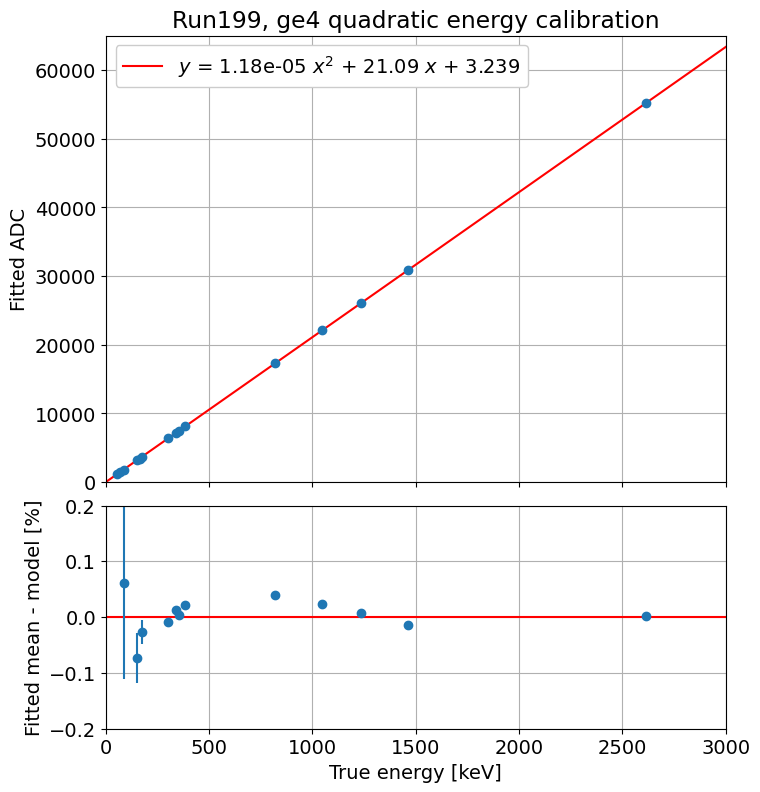

In [29]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})


p, pcov = QuadFit( efit[:] )

# ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

xfit = np.linspace(0.,3000.,200)
yfit = Quadratic(xfit, *p)

print(p)

ax[0].plot(xfit, yfit, '-r',\
          label='$y$ = {:4.4} $x^2$ + {:4.4} $x$ + {:4.4}'.format(p[0], p[1], p[2]))
ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

residuals = efit[:,1] - Quadratic(efit[:,0], *p)

ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/Quadratic(efit[:,0], *p)*100, \
               yerr=efit[:,2]/Quadratic(efit[:,0], *p)*100, \
               fmt='o')
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-0.2, 0.2)

ax[0].legend(framealpha=1.)

ax[1].set_xlabel('True energy [keV]')
ax[0].set_ylabel('Fitted ADC')
ax[0].set_title('Run199, {} quadratic energy calibration'.format(det))
ax[0].set_xlim(0.,3000.)
ax[0].set_ylim(0.,65000.)
ax[0].grid()
ax[1].grid()

plt.savefig('energy_cal_plots/run199_ge4_quadratic_energy_calibration.png',\
           dpi=300, bbox_inches='tight')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10.,3000.)
# plt.ylim(100.,65000.)

plt.show()

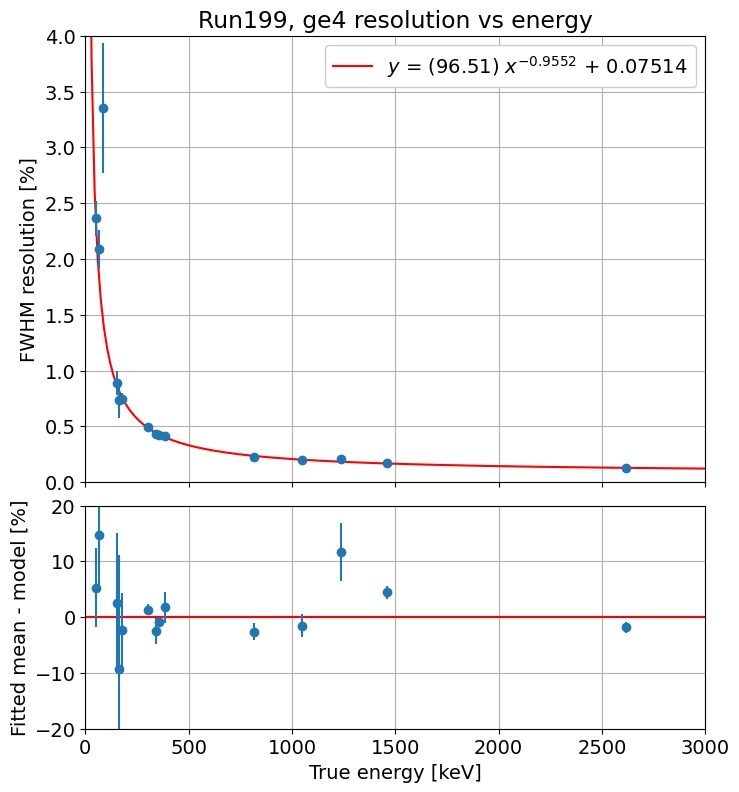

In [30]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})
resolution = sigfit[:,1] / efit[:,1] * 100 * 2.355
resolution_unc = resolution * np.sqrt( (efit[:,2]/efit[:,1])**2 + \
                                      (sigfit[:,2]/sigfit[:,1])**2 )
array_data = np.vstack([sigfit[:,0], resolution, resolution_unc])
p, pcov = PowerLawFit( array_data.T  )
xfit = np.linspace(0.1,3000.,200)
yfit = PowerLaw( xfit, *p)
ax[0].plot(xfit,yfit,'-r',\
          label='$y$ = ({:4.4}) $x^{{{:4.4}}}$ + {:4.4}'.format(p[0],p[1],p[2]))
ax[0].set_title('Run199, {} resolution vs energy'.format(det))

ax[0].errorbar( sigfit[:,0], resolution, yerr = resolution_unc, fmt='o')


ax[1].set_xlabel('True energy [keV]')

ax[0].set_ylabel('FWHM resolution [%]')
ax[0].grid()
ax[0].set_xlim(0.,3000.)
ax[0].set_ylim(0.,4.0)


ax[0].legend(framealpha=1.)

residuals = resolution - PowerLaw(sigfit[:,0], *p)
ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/PowerLaw(sigfit[:,0], *p)*100, \
               yerr=resolution_unc/PowerLaw(sigfit[:,0], *p)*100, \
               fmt='o')
ax[1].grid()
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-20, 20)

plt.savefig('energy_cal_plots/run199_ge4_power_law_resolution_fit_lin.png',\
           dpi=300, bbox_inches='tight')

plt.show()

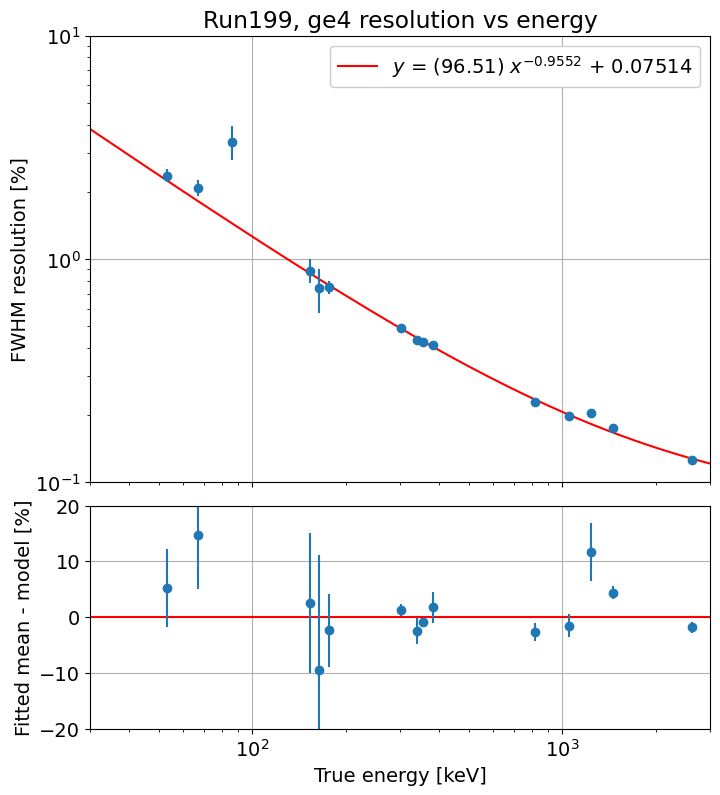

In [31]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})
resolution = sigfit[:,1] / efit[:,1] * 100 * 2.355
resolution_unc = resolution * np.sqrt( (efit[:,2]/efit[:,1])**2 + \
                                      (sigfit[:,2]/sigfit[:,1])**2 )
array_data = np.vstack([sigfit[:,0], resolution, resolution_unc])
p, pcov = PowerLawFit( array_data.T  )
xfit = np.linspace(0.1,3000.,200)
yfit = PowerLaw( xfit, *p)
ax[0].plot(xfit,yfit,'-r',\
          label='$y$ = ({:4.4}) $x^{{{:4.4}}}$ + {:4.4}'.format(p[0],p[1],p[2]))
ax[0].set_title('Run199, {} resolution vs energy'.format(det))

ax[0].errorbar( sigfit[:,0], resolution, yerr = resolution_unc, fmt='o')


ax[1].set_xlabel('True energy [keV]')

ax[0].set_ylabel('FWHM resolution [%]')
ax[0].grid()
ax[0].set_xlim(0.,3000.)
ax[0].set_ylim(0.,2.5)

ax[0].set_xlim(30.,3000.)
ax[0].set_ylim(0.1,10.)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].legend(framealpha=1.)

residuals = resolution - PowerLaw(sigfit[:,0], *p)
ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/PowerLaw(sigfit[:,0], *p)*100, \
               yerr=resolution_unc/PowerLaw(sigfit[:,0], *p)*100, \
               fmt='o')
ax[1].grid()
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-20, 20)

plt.savefig('energy_cal_plots/run199_ge4_power_law_resolution_fit_log.png',\
           dpi=300, bbox_inches='tight')

plt.show()


# Calibrating the planar detectors

In [32]:
fname196 = 'root_data_Xe136_run196.bin_tree.root'
datapath = '/p/lustre1/lenardo1/tunl_cs136_data/'

run196 = GetDataDict( datapath + fname196 )

Opening file...
	ge0
	ge2
	ge4
	ge6


[ 3411.90191267 29902.96107244  3038.73852069 ...  3463.70440226
  2707.71785219 29376.15445832]


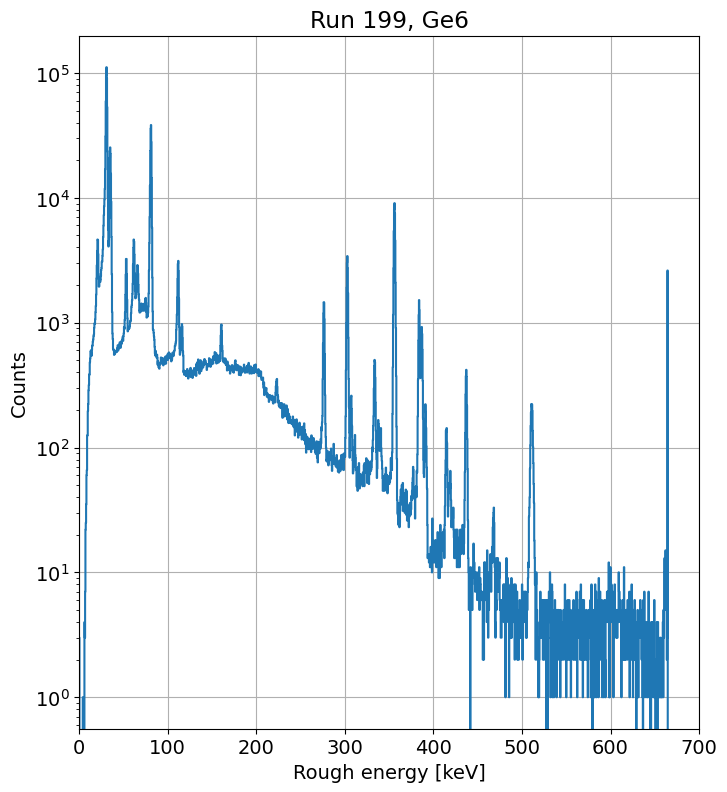

In [33]:
det = 'ge2'

mask = (run196[det]['pileup'] < 1.)

print(run196[det]['raw energy'][mask])

h_ge0_196 = hl.hist( run196[det]['rough energy'][mask],\
                   bins=np.linspace(0.,3000.,8000))
hl.plot1d(h_ge0_196)

# det = 'ge6'
# h_ge6_197 = hl.hist( run197[det]['rough energy'][mask],\
#                    bins = np.linspace(0.,2000.,1000))
#hl.plot1d(h_ge6_197)
plt.xlim(0.,700.)
plt.yscale('log')
plt.xlabel('Rough energy [keV]')
plt.ylabel('Counts')
plt.title('Run 199, Ge6')
plt.grid()
plt.show()

Fitting line at 53.162 keV...


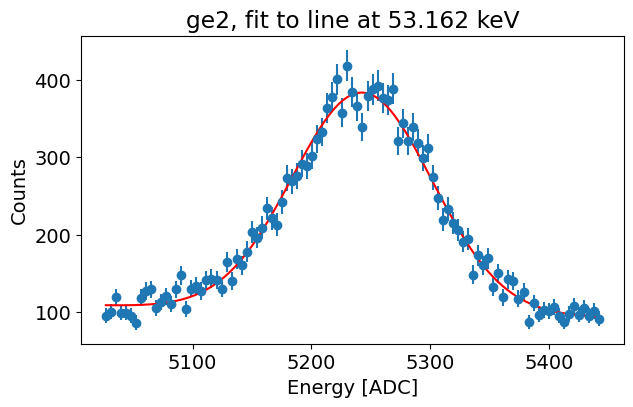

Line at 79.612 keV is too close to another line to fit reliably.
Line at 80.998 keV is too close to another line to fit reliably.
Fitting line at 276.4 keV...


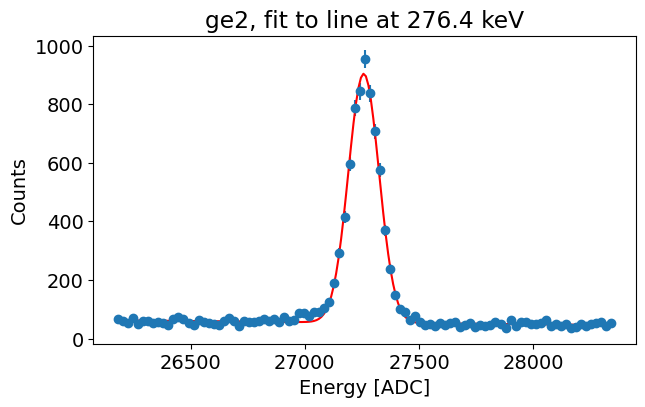

Fitting line at 302.85 keV...


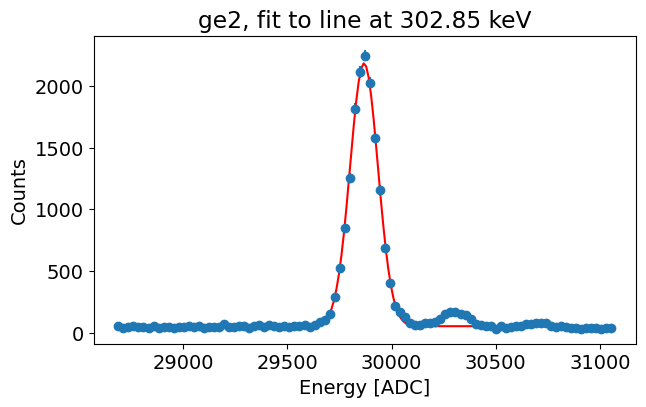

Fitting line at 356.01 keV...


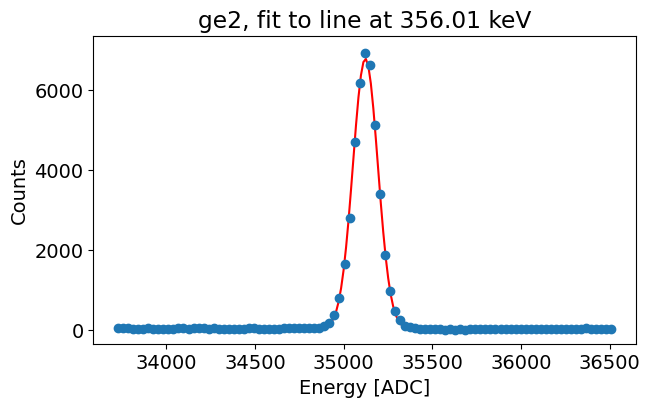

Fitting line at 383.85 keV...


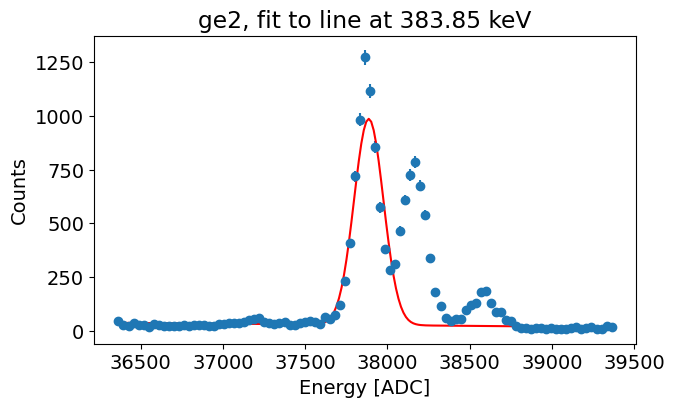

Fitting line at 511.0 keV...


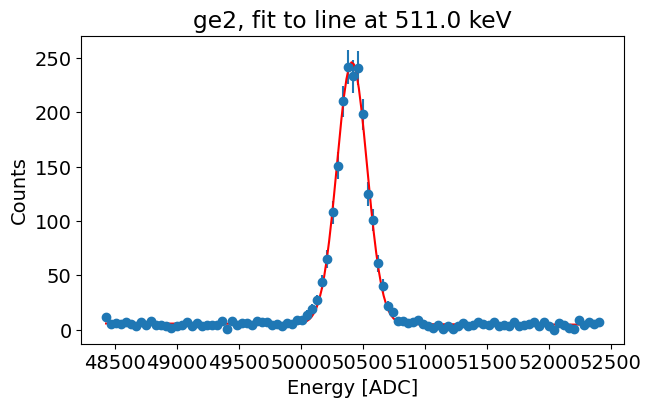

In [34]:
plt.rcParams['figure.figsize'] = [7,4]
plt.rcParams.update({'font.size': 14})

valid_isotopes = ['ba133', 'annihil']
det = 'ge2'
plot=True

e_thresh = 40.
e_max = 700.
intensity_thresh = 0.01
all_lines = np.concatenate([isotopes_dict[iso][:,0] for iso in valid_isotopes])
all_intensities = np.concatenate([isotopes_dict[iso][:,1] for iso in valid_isotopes])
mask = (all_lines > e_thresh) & \
            (all_intensities > intensity_thresh) & \
            (all_lines < e_max)
fit_lines = all_lines[mask]

fit_lines.sort()

# print(fit_lines)

efit = []
sigfit = []

for i,line in enumerate(fit_lines):
    
    line_diffs = np.abs(fit_lines - line)
    if np.sum(line_diffs < 3.) > 1:
        print('Line at {:5.5} keV is too close to another line'.format(line) +\
             ' to fit reliably.')
        continue
    
    print('Fitting line at {:5.5} keV...'.format(line))
    
    
    mask = (run196[det]['rough energy'] > line*0.96) & \
            (run196[det]['rough energy'] < line*1.04) & \
            (run196[det]['pileup'] < 1.)
    
    data = run196[det]['raw energy'][mask]
    
    hfit = hl.hist( data, \
                   bins=np.linspace(np.min(data), np.max(data),100))
    

    p, pcov, xfit, yfit = FitSinglePeak(hfit)
#     print(p)
    
    efit.append( np.array([line, p[1], np.sqrt(pcov[1,1])]) )
    sigfit.append( np.array( [line, p[2], np.sqrt(pcov[2,2])]) )
    
    
    if plot:
        plt.figure(i)

        plt.title('{}, fit to line at {:5.5} keV'.format(det,line))
        plt.xlabel('Energy [ADC]')
        plt.ylabel('Counts')
        plt.errorbar(xfit,yfit,yerr=np.sqrt(yfit), fmt='o')
        xcurve = np.linspace(xfit[0],xfit[-1],200)
        ycurve = GaussianWLinearBkg(xcurve, *p)
        plt.plot(xcurve,ycurve,'-r')
        plt.show()

efit = np.array(efit)
sigfit = np.array(sigfit)



[0.0, 98.65363818891254, 0.0]
[ 6.55149989e-05  9.86275091e+01 -1.53769677e+00]


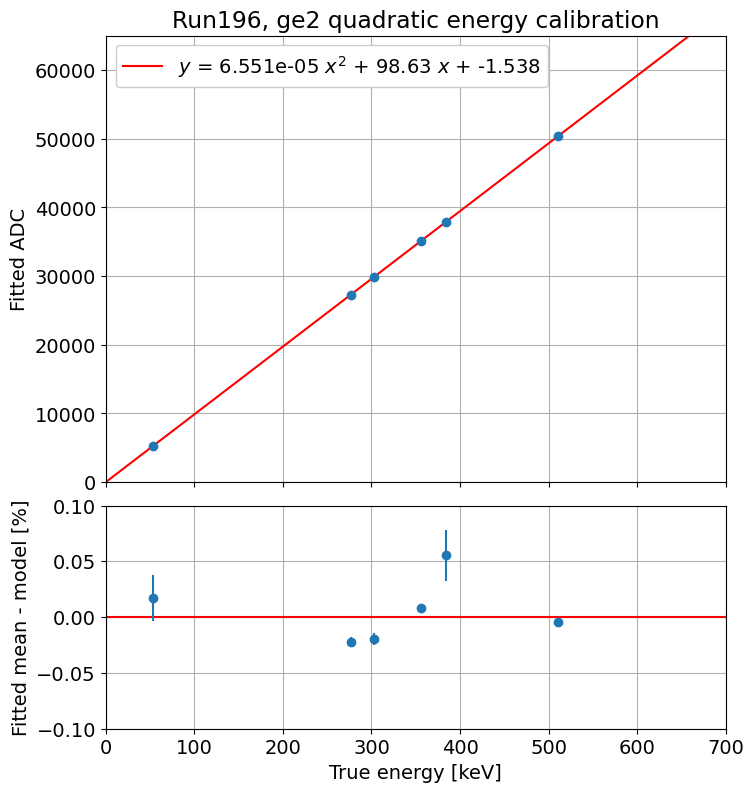

In [35]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})


p, pcov = QuadFit( efit[:] )

# ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

xfit = np.linspace(0.,700.,200)
yfit = Quadratic(xfit, *p)

print(p)

ax[0].plot(xfit, yfit, '-r',\
          label='$y$ = {:4.4} $x^2$ + {:4.4} $x$ + {:4.4}'.format(p[0], p[1], p[2]))
ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

residuals = efit[:,1] - Quadratic(efit[:,0], *p)

ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/Quadratic(efit[:,0], *p)*100, \
               yerr=efit[:,2]/Quadratic(efit[:,0], *p)*100, \
               fmt='o')
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-.1, .1)

ax[0].legend(framealpha=1.)

ax[1].set_xlabel('True energy [keV]')
ax[0].set_ylabel('Fitted ADC')
ax[0].set_title('Run196, {} quadratic energy calibration'.format(det))
ax[0].set_xlim(0.,700.)
ax[0].set_ylim(0.,65000.)
ax[0].grid()
ax[1].grid()

plt.savefig('energy_cal_plots/run196_ge2_quadratic_energy_calibration.png',\
           dpi=300, bbox_inches='tight')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10.,3000.)
# plt.ylim(100.,65000.)

plt.show()

In [36]:
fname307 = 'root_data_Xe136_run307.bin_tree.root'
datapath = '/p/lustre1/lenardo1/tunl_cs136_data/'

run307 = GetDataDict( datapath + fname307 )

Opening file...
	ge0
	ge2
	ge4
	ge6


[12138.81518142 46129.37331174  7491.90659946 ... 25827.07550795
 13737.74278737 18846.19632016]
[48773.44865291 14345.91023326 15891.71414334 ... 20923.91713196
  6083.39950359  5279.9064861 ]


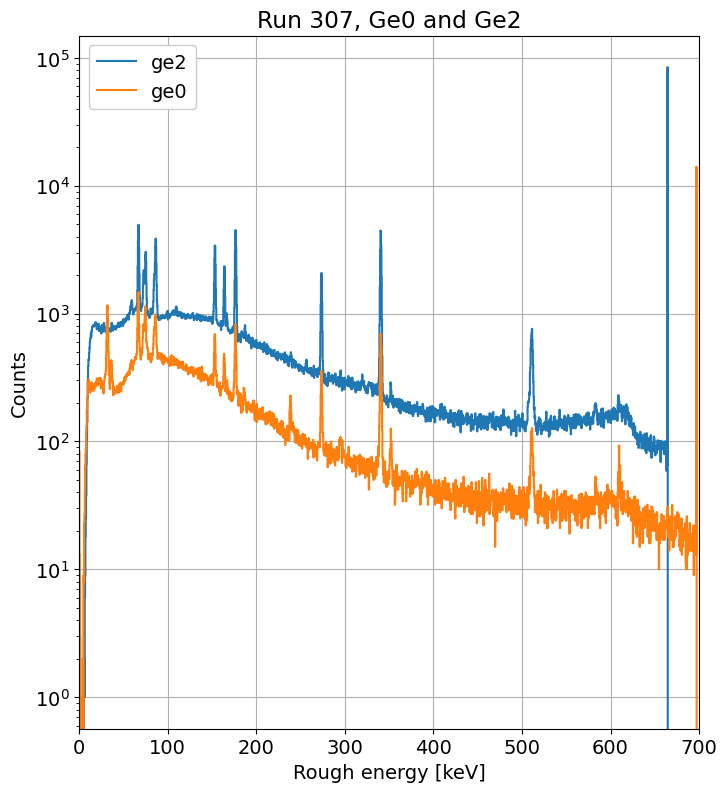

In [37]:
det = 'ge2'

mask = (run307[det]['pileup'] < 1.)

print(run307[det]['raw energy'][mask])

h_ge2_307 = hl.hist( run307[det]['rough energy'][mask],\
                   bins=np.linspace(0.,3000.,8000))
hl.plot1d(h_ge2_307, label='{}'.format(det))

det = 'ge0'

mask = (run307[det]['pileup'] < 1.)

print(run307[det]['raw energy'][mask])

h_ge0_307 = hl.hist( run307[det]['rough energy'][mask],\
                   bins=np.linspace(0.,3000.,8000))
hl.plot1d(h_ge0_307, label='{}'.format(det))

# det = 'ge6'
# h_ge6_197 = hl.hist( run197[det]['rough energy'][mask],\
#                    bins = np.linspace(0.,2000.,1000))
#hl.plot1d(h_ge6_197)
plt.xlim(0.,700.)
plt.yscale('log')
plt.xlabel('Rough energy [keV]')
plt.ylabel('Counts')
plt.title('Run 307, Ge0 and Ge2')
plt.grid()
plt.legend(framealpha=1.)
plt.show()

Fitting line at 66.881 keV...


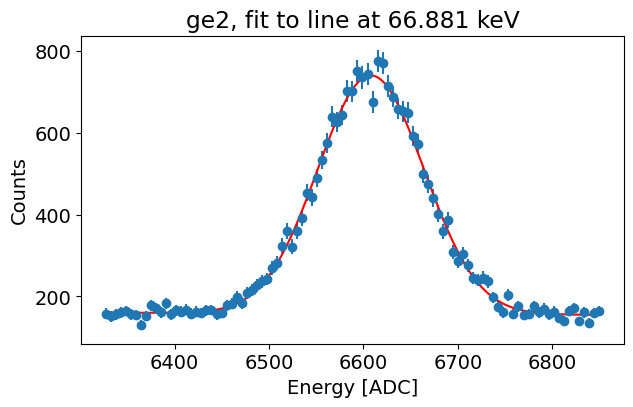

Fitting line at 153.25 keV...


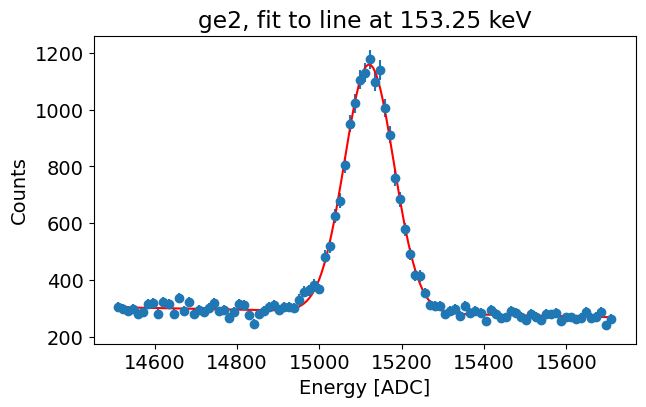

Fitting line at 163.92 keV...


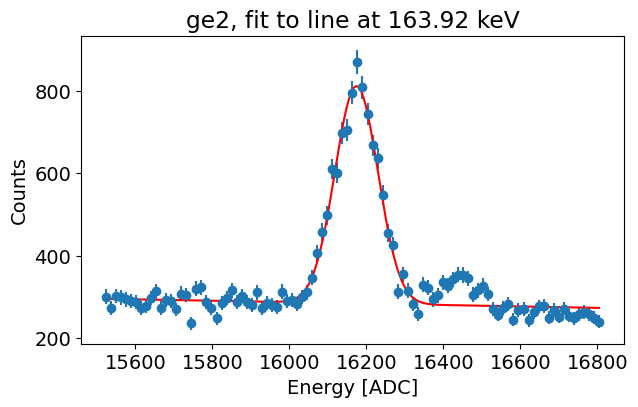

Fitting line at 176.6 keV...


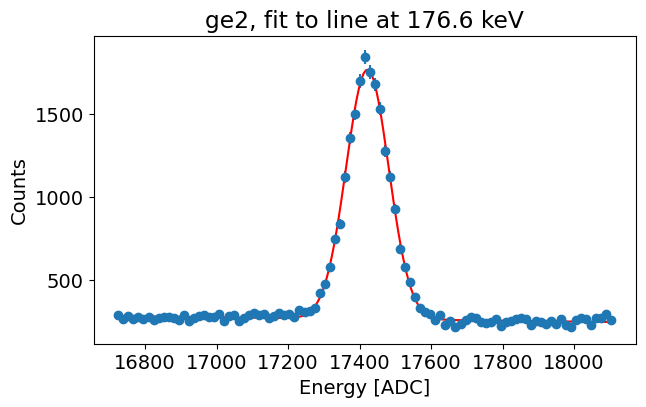

Fitting line at 273.65 keV...


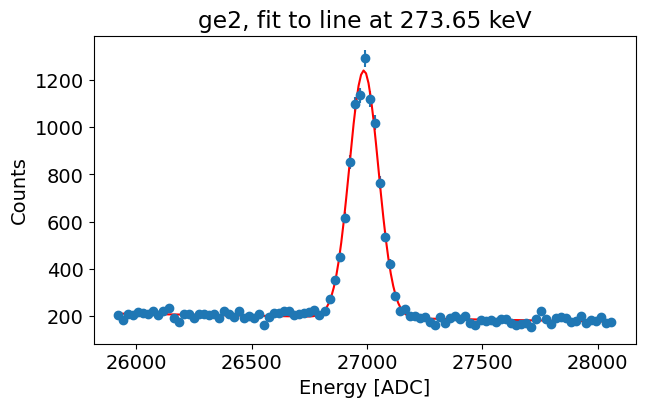

Fitting line at 340.55 keV...


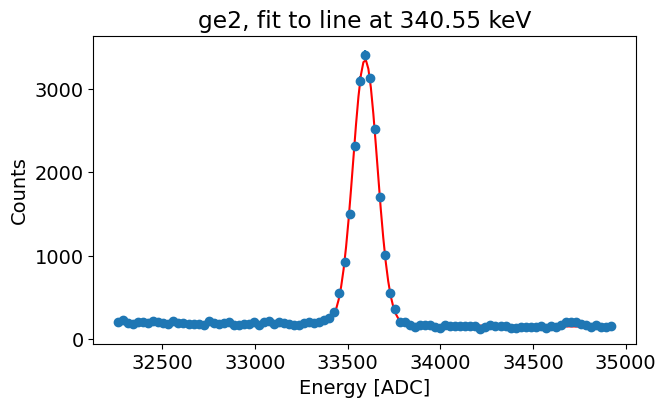

Fitting line at 511.0 keV...


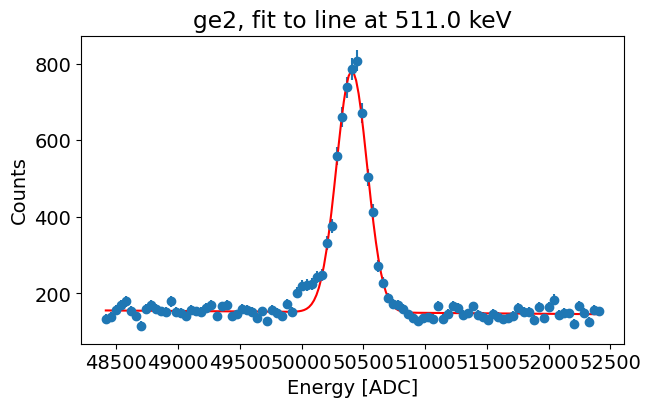

In [38]:
plt.rcParams['figure.figsize'] = [7,4]
plt.rcParams.update({'font.size': 14})

valid_isotopes = ['cs136', 'annihil']
det = 'ge2'
plot=True

e_thresh = 40.
e_max = 700.
intensity_thresh = 0.001
all_lines = np.concatenate([isotopes_dict[iso][:,0] for iso in valid_isotopes])
all_intensities = np.concatenate([isotopes_dict[iso][:,1] for iso in valid_isotopes])
mask = (all_lines > e_thresh) & \
            (all_intensities > intensity_thresh) & \
            (all_lines < e_max)
fit_lines = all_lines[mask]

fit_lines.sort()

# print(fit_lines)

efit = []
sigfit = []

for i,line in enumerate(fit_lines):
    
    if np.abs(line - 86) < 1.:
        continue
    
    line_diffs = np.abs(fit_lines - line)
    if np.sum(line_diffs < .1) > 1:
        print('Line at {:5.5} keV is too close to another line'.format(line) +\
             ' to fit reliably.')
        continue
    
    print('Fitting line at {:5.5} keV...'.format(line))
    
    
    mask = (run307[det]['rough energy'] > line*0.96) & \
            (run307[det]['rough energy'] < line*1.04) & \
            (run307[det]['pileup'] < 1.)
    
    data = run307[det]['raw energy'][mask]
    
    hfit = hl.hist( data, \
                   bins=np.linspace(np.min(data), np.max(data),100))
    

    p, pcov, xfit, yfit = FitSinglePeak(hfit)
#     print(p)
    
    efit.append( np.array([line, p[1], np.sqrt(pcov[1,1])]) )
    sigfit.append( np.array( [line, p[2], np.sqrt(pcov[2,2])]) )
    
    
    if plot:
        plt.figure(i)

        plt.title('{}, fit to line at {:5.5} keV'.format(det,line))
        plt.xlabel('Energy [ADC]')
        plt.ylabel('Counts')
        plt.errorbar(xfit,yfit,yerr=np.sqrt(yfit), fmt='o')
        xcurve = np.linspace(xfit[0],xfit[-1],200)
        ycurve = GaussianWLinearBkg(xcurve, *p)
        plt.plot(xcurve,ycurve,'-r')
        plt.show()

efit = np.array(efit)
sigfit = np.array(sigfit)



[0.0, 98.64340505342693, 0.0]
[2.35621651e-04 9.85061664e+01 1.86582321e+01]


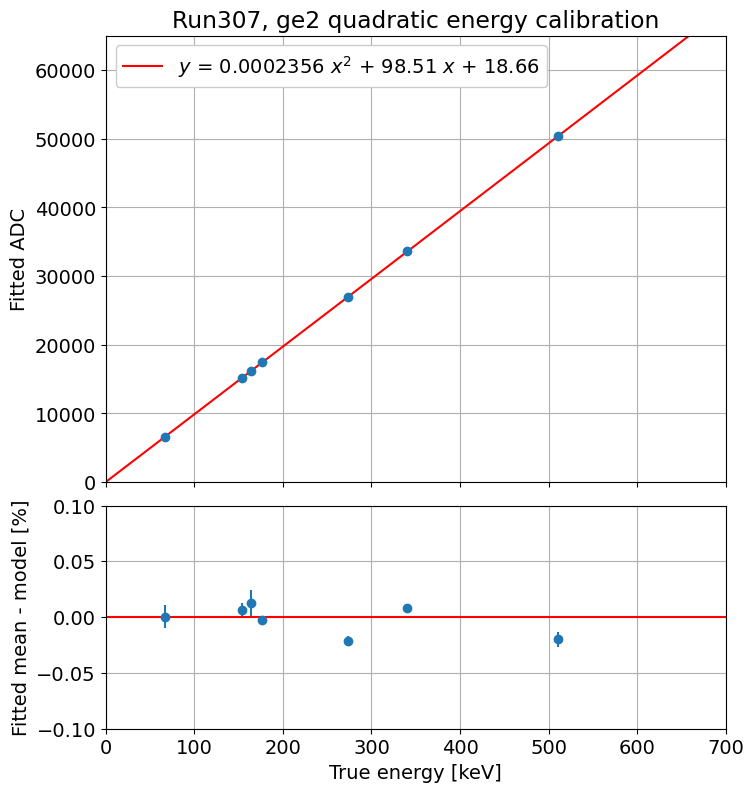

In [39]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})


p, pcov = QuadFit( efit[:] )

# ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

xfit = np.linspace(0.,700.,200)
yfit = Quadratic(xfit, *p)

print(p)

ax[0].plot(xfit, yfit, '-r',\
          label='$y$ = {:4.4} $x^2$ + {:4.4} $x$ + {:4.4}'.format(p[0], p[1], p[2]))
ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

residuals = efit[:,1] - Quadratic(efit[:,0], *p)

ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/Quadratic(efit[:,0], *p)*100, \
               yerr=efit[:,2]/Quadratic(efit[:,0], *p)*100, \
               fmt='o')
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-.1, .1)

ax[0].legend(framealpha=1.)

ax[1].set_xlabel('True energy [keV]')
ax[0].set_ylabel('Fitted ADC')
ax[0].set_title('Run307, {} quadratic energy calibration'.format(det))
ax[0].set_xlim(0.,700.)
ax[0].set_ylim(0.,65000.)
ax[0].grid()
ax[1].grid()

plt.savefig('energy_cal_plots/run307_ge2_quadratic_energy_calibration.png',\
           dpi=300, bbox_inches='tight')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10.,3000.)
# plt.ylim(100.,65000.)

plt.show()

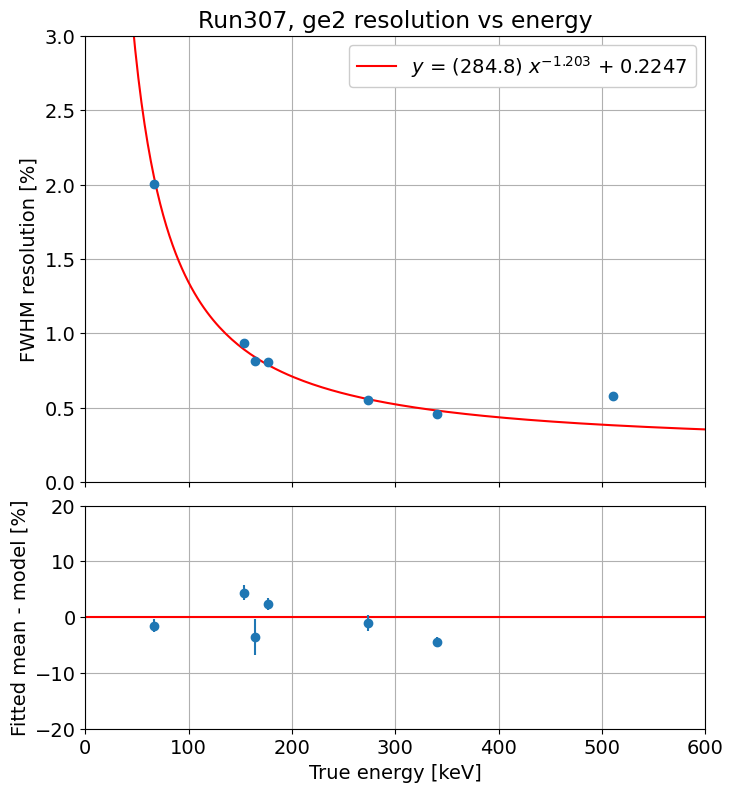

In [40]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})
resolution = sigfit[:,1] / efit[:,1] * 100 * 2.355
resolution_unc = resolution * np.sqrt( (efit[:,2]/efit[:,1])**2 + \
                                      (sigfit[:,2]/sigfit[:,1])**2 )
array_data = np.vstack([sigfit[:,0], resolution, resolution_unc])
p, pcov = PowerLawFit( array_data.T  )
xfit = np.linspace(0.1,600.,200)
yfit = PowerLaw( xfit, *p)
ax[0].plot(xfit,yfit,'-r',\
          label='$y$ = ({:4.4}) $x^{{{:4.4}}}$ + {:4.4}'.format(p[0],p[1],p[2]))
ax[0].set_title('Run307, {} resolution vs energy'.format(det))

ax[0].errorbar( sigfit[:,0], resolution, yerr = resolution_unc, fmt='o')


ax[1].set_xlabel('True energy [keV]')

ax[0].set_ylabel('FWHM resolution [%]')
ax[0].grid()
ax[0].set_xlim(0.,600.)
ax[0].set_ylim(0.,3.0)


ax[0].legend(framealpha=1.)

residuals = resolution - PowerLaw(sigfit[:,0], *p)
ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/PowerLaw(sigfit[:,0], *p)*100, \
               yerr=resolution_unc/PowerLaw(sigfit[:,0], *p)*100, \
               fmt='o')
ax[1].grid()
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-20, 20)

plt.savefig('energy_cal_plots/run307_ge2_power_law_resolution_fit_lin.png',\
           dpi=300, bbox_inches='tight')

plt.show()

# Fit Ge0 using Run307

In [41]:
lines = isotopes_dict['cs136']
xray_lines = lines[lines[:,0] < 40.]
print(xray_lines)

[[3.1817e+01 3.8600e-02]
 [3.2194e+01 7.0400e-02]
 [3.6304e+01 6.7400e-03]
 [3.6378e+01 1.3000e-02]
 [3.7255e+01 4.1100e-03]]


In [42]:
def Gaussian(x, A, mu, sig):
    return A/np.sqrt(2*np.pi*sig**2) * np.exp(-(x-mu)**2/(2*sig**2))


#####################################################################
def Cs136XraysSpectrum( x, A1, mu1, sig1, A2, mu2, sig2, a, b ):
    
    first_amp_ratio = 3.8600e-02/7.0400e-02
    first_e_ratio = 3.1817e+01/3.2194e+01
    
    first_spectrum = A1/np.sqrt(2*np.pi*sig1**2) * \
                        ( first_amp_ratio * \
                             np.exp(-(x-mu1*first_e_ratio)**2/(2*sig1**2)) + \
                            np.exp(-(x-mu1)**2/(2*sig1**2)) )
    
    second_amp_ratio_1 = 6.7400e-03/1.3000e-02
    second_e_ratio_1 = 3.6304e+01/3.6378e+01
    second_amp_ratio_2 = 4.1100e-03/1.3000e-02
    second_e_ratio_2 = 3.7255e+01/3.6378e+01
    
    second_spectrum = A2/np.sqrt(2*np.pi*sig2**2) * \
                        ( second_amp_ratio_1 * \
                             np.exp(-(x-mu2*second_e_ratio_1)**2/(2*sig2**2)) + \
                         second_amp_ratio_2 * \
                             np.exp(-(x-mu2*second_e_ratio_2)**2/(2*sig2**2)) + \
                            np.exp(-(x-mu2)**2/(2*sig2**2)) )
    
    return first_spectrum + second_spectrum + a*x + b


#####################################################################
def FitCs136Xrays( hist, fitrange=None, p0=None ):
    bin_centers = (hist.bins[0][1:] + hist.bins[0][:-1])/2.
    bin_vals = hist.values
    
    mask = np.ones(len(bin_vals), dtype=bool)
    if fitrange is not None:
        mask = (bin_centers > fitrange[0]) & (bin_centers < fitrange[1])
        
    xfit = bin_centers[mask]
    yfit = bin_vals[mask]
    
    if p0 is None:
        A1_guess = np.max(yfit) * np.sqrt(2*np.pi*100)
        mu1_guess = xfit[np.where(yfit==np.max(yfit))[0]][0]
        sig1_guess = 10.
        A2_guess = A1_guess * 1.3/7.0
        mu2_guess = mu1_guess * 3.6378e+01/3.2194e+01
        sig2_guess = sig1_guess
        a_guess = 0.
        b_guess = np.mean(yfit[0:3])
        
        p0 = [A1_guess, 
              mu1_guess, 
              sig1_guess, 
              A2_guess, 
              mu2_guess, 
              sig2_guess, 
              a_guess, 
              b_guess]
    try:
        if np.sum((yfit==0.)) == 0:
            p, pcov = curve_fit(Cs136XraysSpectrum, xfit, yfit, \
                            sigma=np.sqrt(yfit),\
                           p0=p0)
        else:
            p, pcov = curve_fit(Cs136XraysSpectrum, xfit, yfit, \
                           p0=p0)
    except:
        print('Unable to fit.')
        
        p = np.array(p0)
        pcov = np.zeros((len(p0), len(p0)))
        
    return p, pcov, xfit, yfit
    
    
    

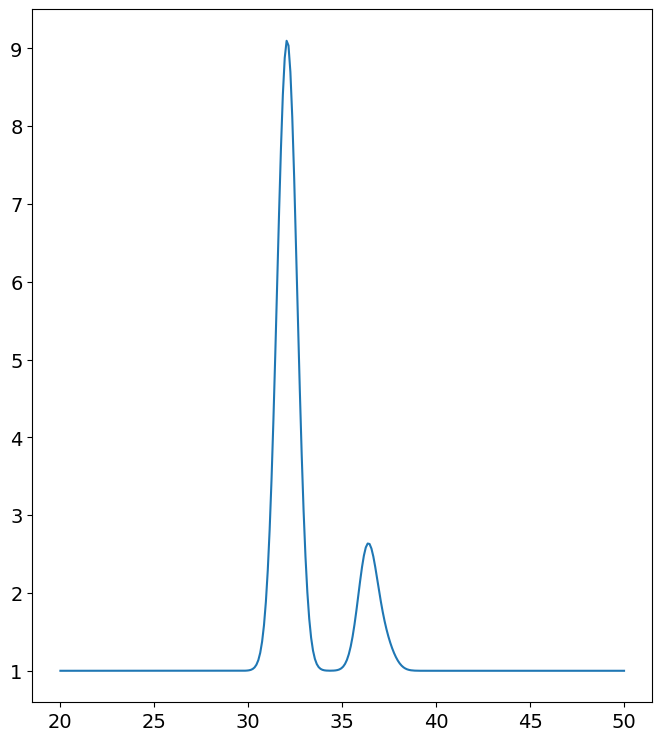

In [43]:
x = np.linspace(20.,50.,300)
y = Cs136XraysSpectrum(x,7.,3.2194e+01,0.5,1.3, 3.6378e+01,0.5,0.,1.)
plt.plot(x,y)
plt.show()

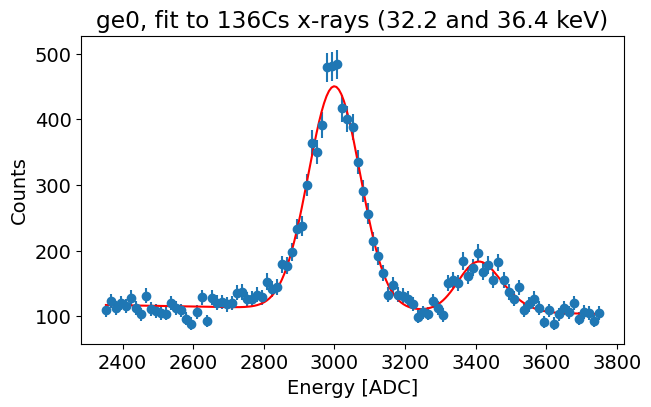

Fitting line at 66.881 keV...


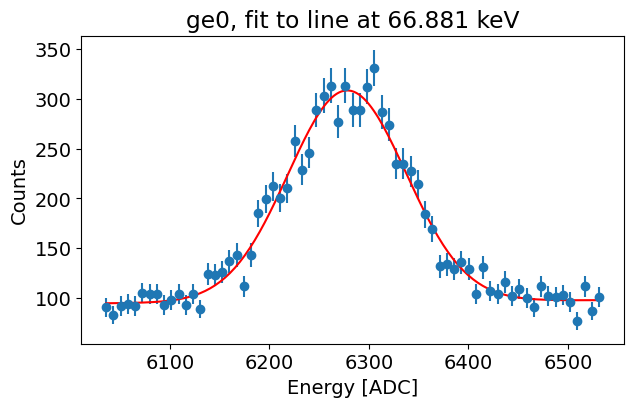

Fitting line at 153.25 keV...


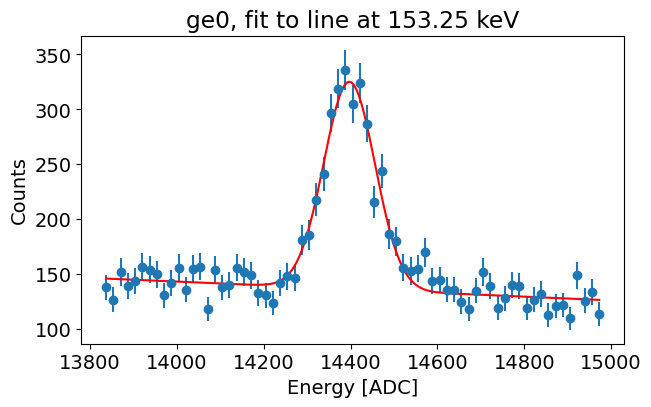

Fitting line at 163.92 keV...


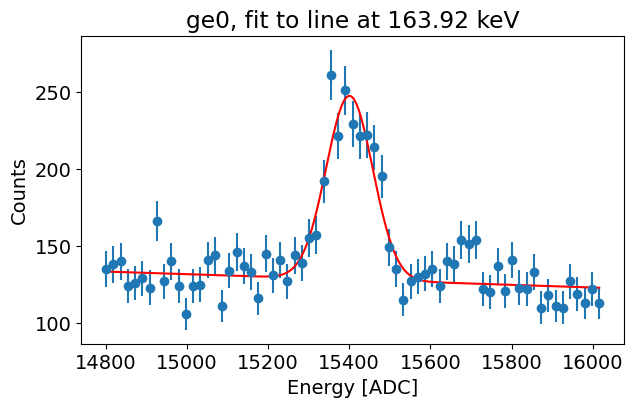

Fitting line at 176.6 keV...


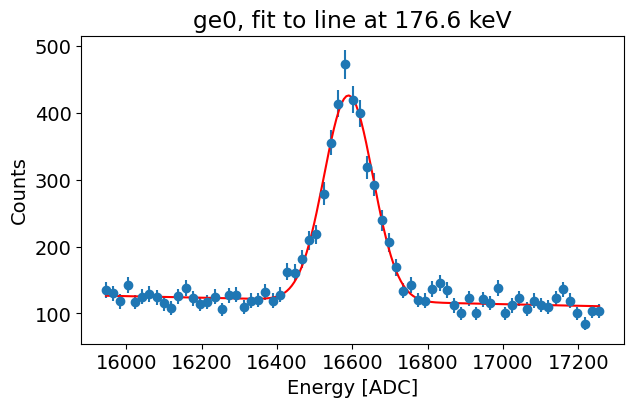

Fitting line at 273.65 keV...


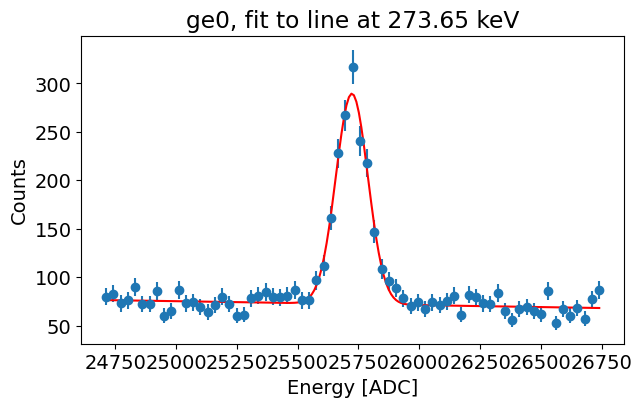

Fitting line at 340.55 keV...


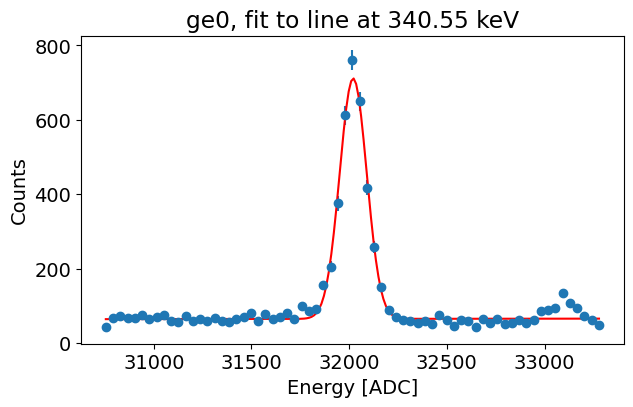

Fitting line at 511.0 keV...


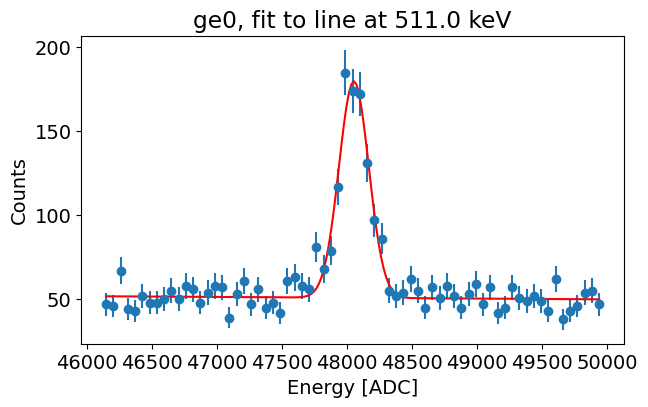

In [44]:
plt.rcParams['figure.figsize'] = [7,4]
plt.rcParams.update({'font.size': 14})

valid_isotopes = ['cs136', 'annihil']
det = 'ge0'
plot=True

e_thresh = 40.
e_max = 700.
intensity_thresh = 0.001
all_lines = np.concatenate([isotopes_dict[iso][:,0] for iso in valid_isotopes])
all_intensities = np.concatenate([isotopes_dict[iso][:,1] for iso in valid_isotopes])
mask = (all_lines > e_thresh) & \
            (all_intensities > intensity_thresh) & \
            (all_lines < e_max)
fit_lines = all_lines[mask]

fit_lines.sort()

# print(fit_lines)

efit = []
sigfit = []

#############################
# Fit the X-rays first
mask = (run307[det]['rough energy'] > 25.) & \
            (run307[det]['rough energy'] < 40.) & \
            (run307[det]['pileup'] < 1.)
data = run307[det]['raw energy'][mask]
hfit = hl.hist( data, \
                   bins=np.linspace(np.min(data), np.max(data),100))
p, pcov, xfit, yfit = FitCs136Xrays(hfit)

efit.append( np.array([3.2194e+01, p[1], np.sqrt(pcov[1,1])]) )
sigfit.append( np.array( [3.2194e+01, p[2], np.sqrt(pcov[2,2])]) )

efit.append( np.array([3.6378e+01, p[4], np.sqrt(pcov[4,4])]) )
sigfit.append( np.array( [3.6378e+01, p[5], np.sqrt(pcov[5,5])]) )


if plot:
    plt.figure(20)

    plt.title('{}, fit to 136Cs x-rays (32.2 and 36.4 keV)'.format(det))
    plt.xlabel('Energy [ADC]')
    plt.ylabel('Counts')
    plt.errorbar(xfit,yfit,yerr=np.sqrt(yfit), fmt='o')
    xcurve = np.linspace(xfit[0],xfit[-1],200)
    ycurve = Cs136XraysSpectrum(xcurve, *p)
    plt.plot(xcurve,ycurve,'-r')
    plt.show()

    
#############################

for i,line in enumerate(fit_lines):
    
    if np.abs(line - 86) < 1.:
        continue
    
    line_diffs = np.abs(fit_lines - line)
    if np.sum(line_diffs < .01) > 1:
        print('Line at {:5.5} keV is too close to another line'.format(line) +\
             ' to fit reliably.')
        continue
    
    print('Fitting line at {:5.5} keV...'.format(line))
    
    if line > 50.:
    
        mask = (run307[det]['rough energy'] > line*0.96) & \
            (run307[det]['rough energy'] < line*1.04) & \
            (run307[det]['pileup'] < 1.)
    else:
        mask = (run307[det]['rough energy'] > line*0.92) & \
            (run307[det]['rough energy'] < line*1.08) & \
            (run307[det]['pileup'] < 1.)
    
    data = run307[det]['raw energy'][mask]
    
    hfit = hl.hist( data, \
                   bins=np.linspace(np.min(data), np.max(data),70))
    

    p, pcov, xfit, yfit = FitSinglePeak(hfit)
#     print(p)
    
    efit.append( np.array([line, p[1], np.sqrt(pcov[1,1])]) )
    sigfit.append( np.array( [line, p[2], np.sqrt(pcov[2,2])]) )
    
    
    if plot:
        plt.figure(i)

        plt.title('{}, fit to line at {:5.5} keV'.format(det,line))
        plt.xlabel('Energy [ADC]')
        plt.ylabel('Counts')
        plt.errorbar(xfit,yfit,yerr=np.sqrt(yfit), fmt='o')
        xcurve = np.linspace(xfit[0],xfit[-1],200)
        ycurve = GaussianWLinearBkg(xcurve, *p)
        plt.plot(xcurve,ycurve,'-r')
        plt.show()

efit = np.array(efit)
sigfit = np.array(sigfit)



[0.0, 94.03729537255802, 0.0]
[ 1.06052329e-04  9.40205883e+01 -1.33952472e+01]


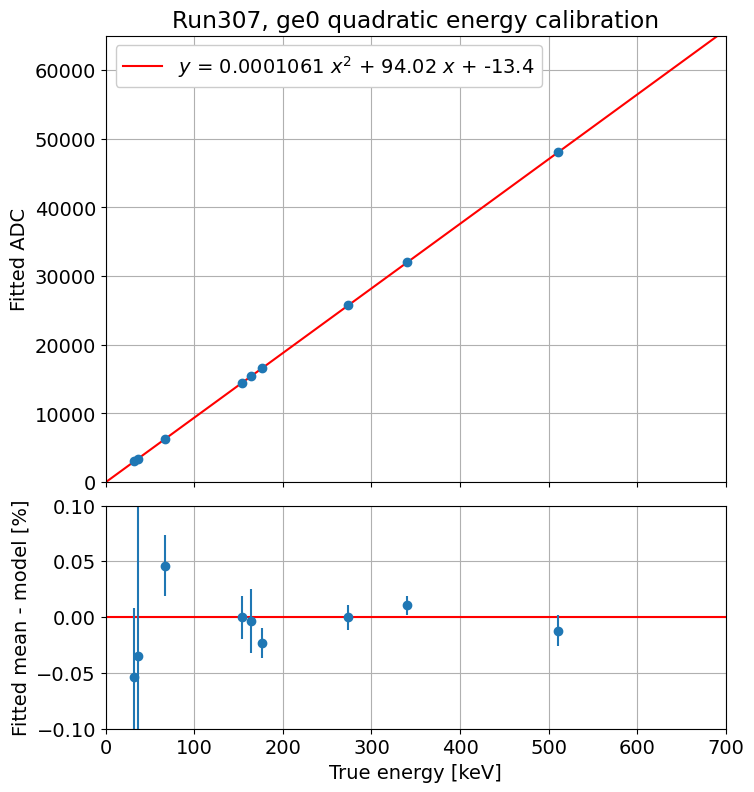

In [45]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})


p, pcov = QuadFit( efit[:] )

# ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

xfit = np.linspace(0.,700.,200)
yfit = Quadratic(xfit, *p)

print(p)

ax[0].plot(xfit, yfit, '-r',\
          label='$y$ = {:4.4} $x^2$ + {:4.4} $x$ + {:4.4}'.format(p[0], p[1], p[2]))
ax[0].errorbar( efit[:,0], efit[:,1], yerr=efit[:,2], fmt='o')

residuals = efit[:,1] - Quadratic(efit[:,0], *p)

ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/Quadratic(efit[:,0], *p)*100, \
               yerr=efit[:,2]/Quadratic(efit[:,0], *p)*100, \
               fmt='o')
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-.1, .1)

ax[0].legend(framealpha=1.)

ax[1].set_xlabel('True energy [keV]')
ax[0].set_ylabel('Fitted ADC')
ax[0].set_title('Run307, {} quadratic energy calibration'.format(det))
ax[0].set_xlim(0.,700.)
ax[0].set_ylim(0.,65000.)
ax[0].grid()
ax[1].grid()

plt.savefig('energy_cal_plots/run307_ge0_quadratic_energy_calibration.png',\
           dpi=300, bbox_inches='tight')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10.,3000.)
# plt.ylim(100.,65000.)

plt.show()

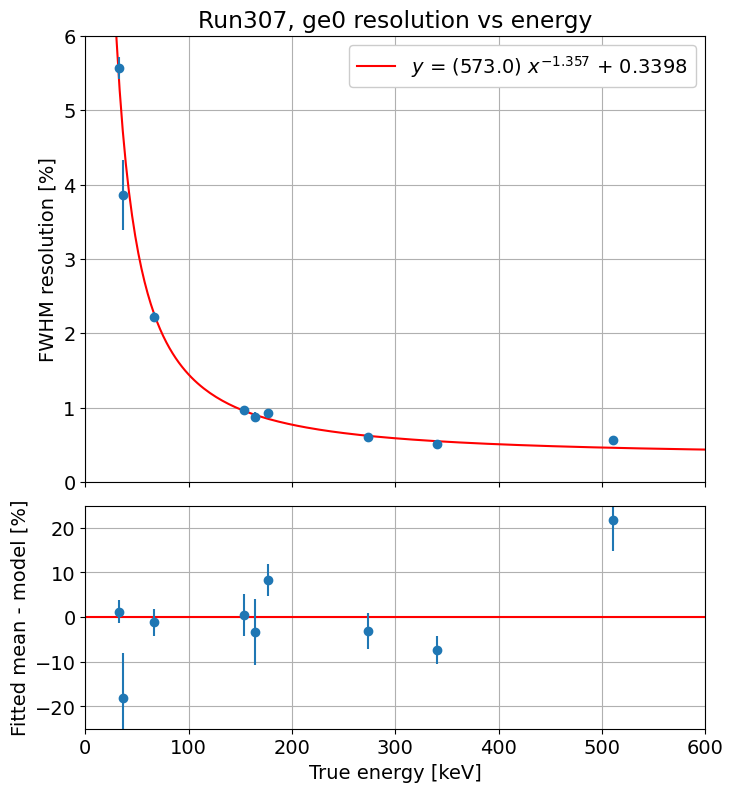

In [46]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})
resolution = sigfit[:,1] / efit[:,1] * 100 * 2.355
resolution_unc = resolution * np.sqrt( (efit[:,2]/efit[:,1])**2 + \
                                      (sigfit[:,2]/sigfit[:,1])**2 )
array_data = np.vstack([sigfit[:,0], resolution, resolution_unc])
p, pcov = PowerLawFit( array_data.T  )
xfit = np.linspace(0.1,600.,200)
yfit = PowerLaw( xfit, *p)
ax[0].plot(xfit,yfit,'-r',\
          label='$y$ = ({:4.4}) $x^{{{:4.4}}}$ + {:4.4}'.format(p[0],p[1],p[2]))
ax[0].set_title('Run307, {} resolution vs energy'.format(det))

ax[0].errorbar( sigfit[:,0], resolution, yerr = resolution_unc, fmt='o')


ax[1].set_xlabel('True energy [keV]')

ax[0].set_ylabel('FWHM resolution [%]')
ax[0].grid()
ax[0].set_xlim(0.,600.)
ax[0].set_ylim(0.,6.0)


ax[0].legend(framealpha=1.)

residuals = resolution - PowerLaw(sigfit[:,0], *p)
ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/PowerLaw(sigfit[:,0], *p)*100, \
               yerr=resolution_unc/PowerLaw(sigfit[:,0], *p)*100, \
               fmt='o')
ax[1].grid()
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-25, 25)


plt.show()

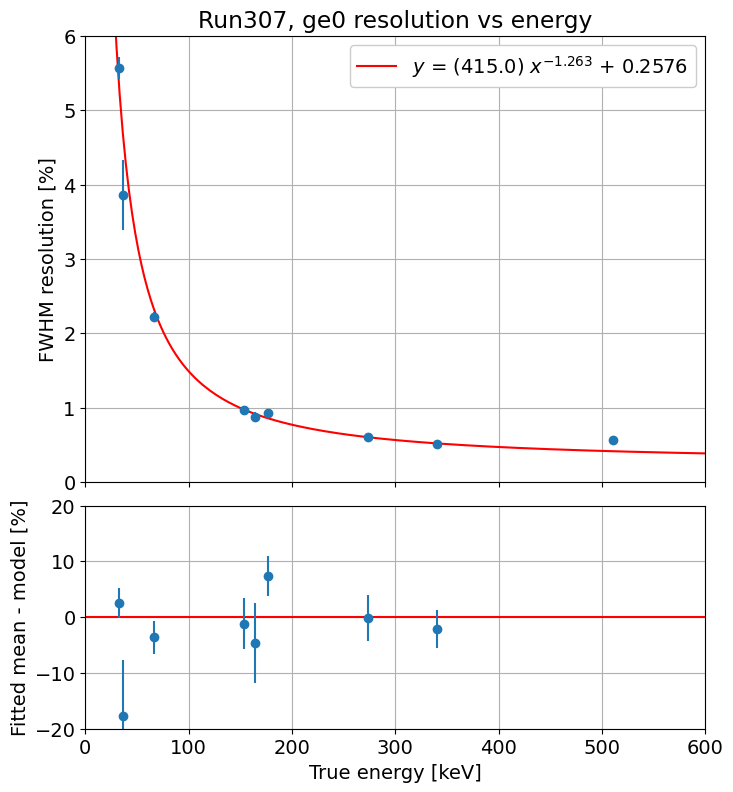

In [47]:
plt.rcParams['figure.figsize'] = [8,9]
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,\
                       gridspec_kw={'height_ratios': [3, 1.5],\
                                   'hspace':0.07})
resolution = sigfit[:,1] / efit[:,1] * 100 * 2.355
resolution_unc = resolution * np.sqrt( (efit[:,2]/efit[:,1])**2 + \
                                      (sigfit[:,2]/sigfit[:,1])**2 )
array_data = np.vstack([sigfit[:,0][:-1], resolution[:-1], resolution_unc[:-1]])
p, pcov = PowerLawFit( array_data.T  )
xfit = np.linspace(0.1,600.,200)
yfit = PowerLaw( xfit, *p)
ax[0].plot(xfit,yfit,'-r',\
          label='$y$ = ({:4.4}) $x^{{{:4.4}}}$ + {:4.4}'.format(p[0],p[1],p[2]))
ax[0].set_title('Run307, {} resolution vs energy'.format(det))

ax[0].errorbar( sigfit[:,0], resolution, yerr = resolution_unc, fmt='o')


ax[1].set_xlabel('True energy [keV]')

ax[0].set_ylabel('FWHM resolution [%]')
ax[0].grid()
ax[0].set_xlim(0.,600.)
ax[0].set_ylim(0.,6.0)


ax[0].legend(framealpha=1.)

residuals = resolution - PowerLaw(sigfit[:,0], *p)
ax[1].plot(xfit, np.zeros(len(xfit)), '-r')
ax[1].errorbar(efit[:,0], residuals/PowerLaw(sigfit[:,0], *p)*100, \
               yerr=resolution_unc/PowerLaw(sigfit[:,0], *p)*100, \
               fmt='o')
ax[1].grid()
ax[1].set_ylabel('Fitted mean - model [%]')
ax[1].set_ylim(-20, 20)

plt.savefig('energy_cal_plots/run307_ge0_power_law_resolution_fit_lin.png',\
           dpi=300, bbox_inches='tight')

plt.show()

# Looking at Run307 lines

In [53]:
import os
import pickle



histdir = '/p/lustre1/lenardo1/tunl_cs136_data/histograms/'
histfiles = [filename for filename in os.listdir(histdir) \
                         if 'run307' in filename]
# print(histfiles)
calibrated_hists = {}

for filename in histfiles:
    
    det = filename.split('_')[5]
    
    with open(histdir + filename, 'rb') as pklfile:
        calibrated_hists[det] =  pickle.load(pklfile) 

print(calibrated_hists)

{'ge0': Hist(4999 bins in [0.0,700.0], with sum 280671.0, 45 empty bins, and 0 non-finite values), 'ge2': Hist(4999 bins in [0.0,700.0], with sum 900651.0, 290 empty bins, and 0 non-finite values), 'ge4': Hist(14999 bins in [0.0,3200.0], with sum 7339718.0, 2755 empty bins, and 0 non-finite values), 'ge6': Hist(14999 bins in [0.0,3200.0], with sum 4596650.0, 2731 empty bins, and 0 non-finite values)}


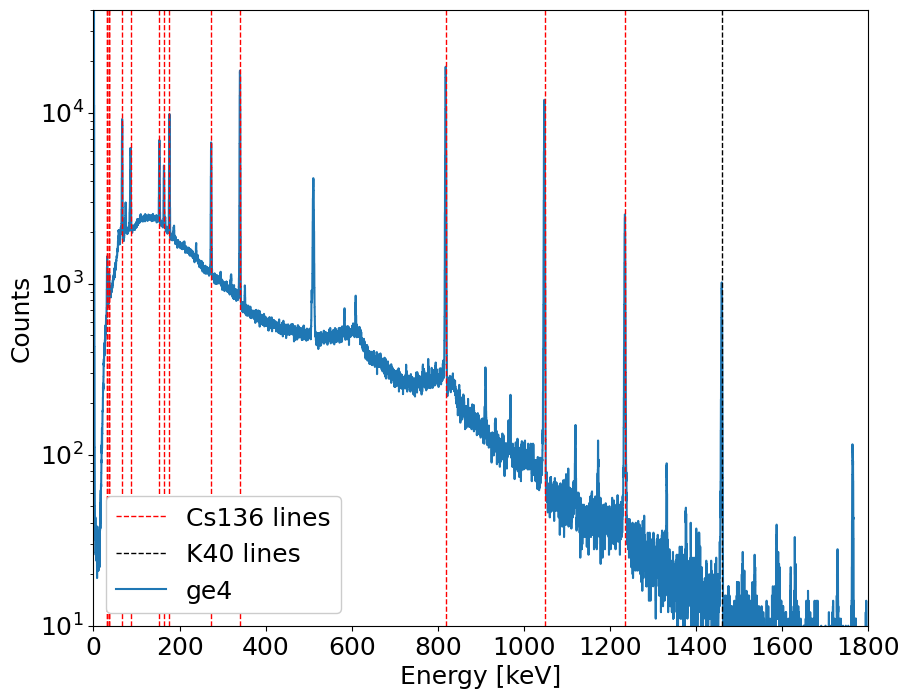

In [72]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 18})

for det, hist in calibrated_hists.items():
    if '4' in det:
        hl.plot1d( hist, label=det )
    
ymin = 10.
ymax = 4e4
    
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(0.,1800.)
plt.ylim(ymin,ymax)


for i, line in enumerate(cs136_list):
    if i == 0:
        label = 'Cs136 lines'
    else:
        label = ''
        
    plt.plot( np.ones(20)*line[0], np.linspace(ymin,ymax,20), \
             '--r', linewidth=1, label = label)
#     if line[0] > 1022.:
#         plt.plot( np.ones(20)*(line[0]-511), np.linspace(ymin,ymax,20), \
#              '--', color=(1.,0.5,0.5), linewidth=1, label = label)

        
for i, line in enumerate(k40_list):
    if i == 0:
        label = 'K40 lines'
    else:
        label = ''
        
    plt.plot( np.ones(20)*line[0], np.linspace(ymin,ymax,20), \
             '--k', linewidth=1, label = label)
#     if line[0] > 1022.:
#         plt.plot( np.ones(20)*(line[0]-511), np.linspace(ymin,ymax,20), \
#              '--', color=(0.5,0.5,0.5), linewidth=1, label = label)
#         plt.plot( np.ones(20)*(line[0]-1022), np.linspace(ymin,ymax,20), \
#              '--', color=(0.5,0.5,0.5), linewidth=1, label = label)
    

plt.legend( framealpha=1 )

plt.savefig('run307_activation_spectrum.png',dpi=300,bbox_inches='tight')

plt.show()

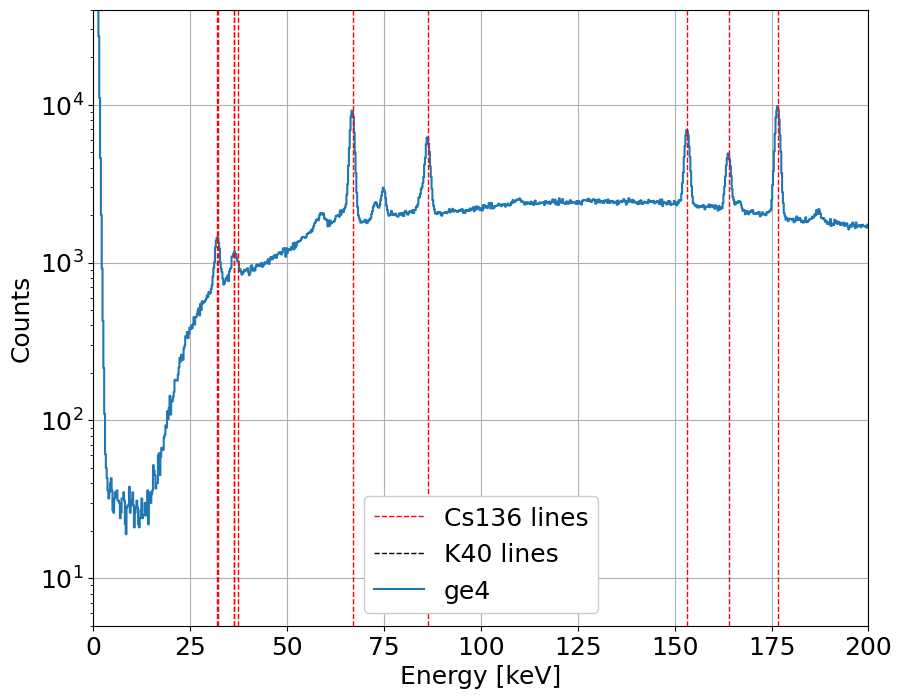

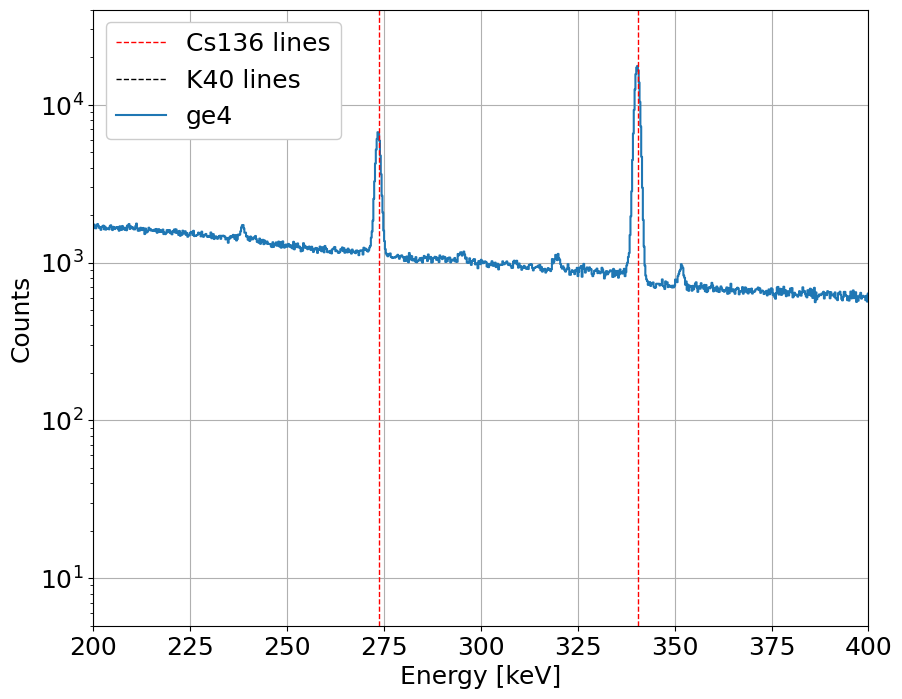

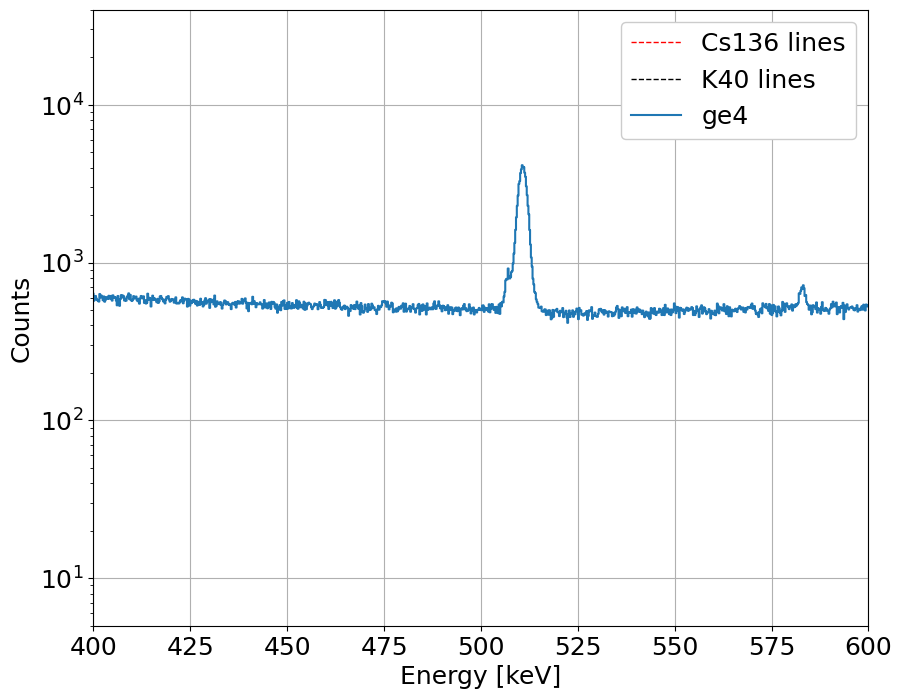

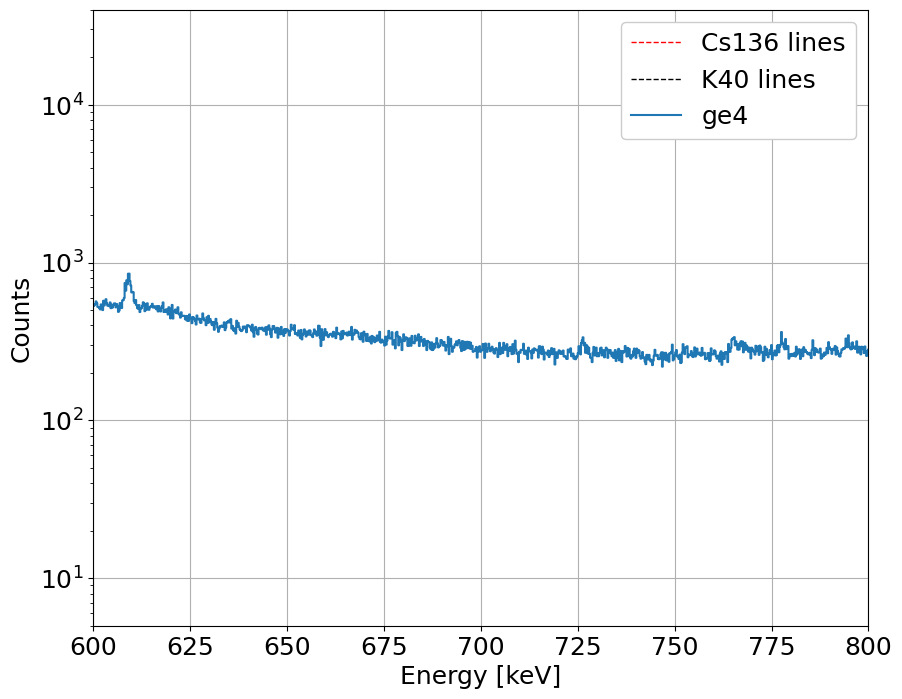

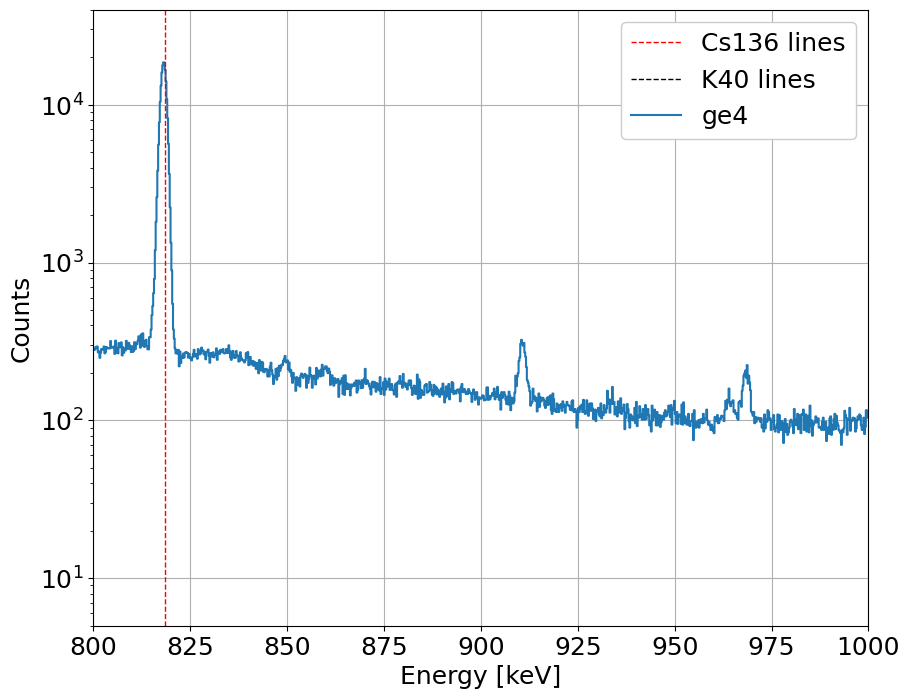

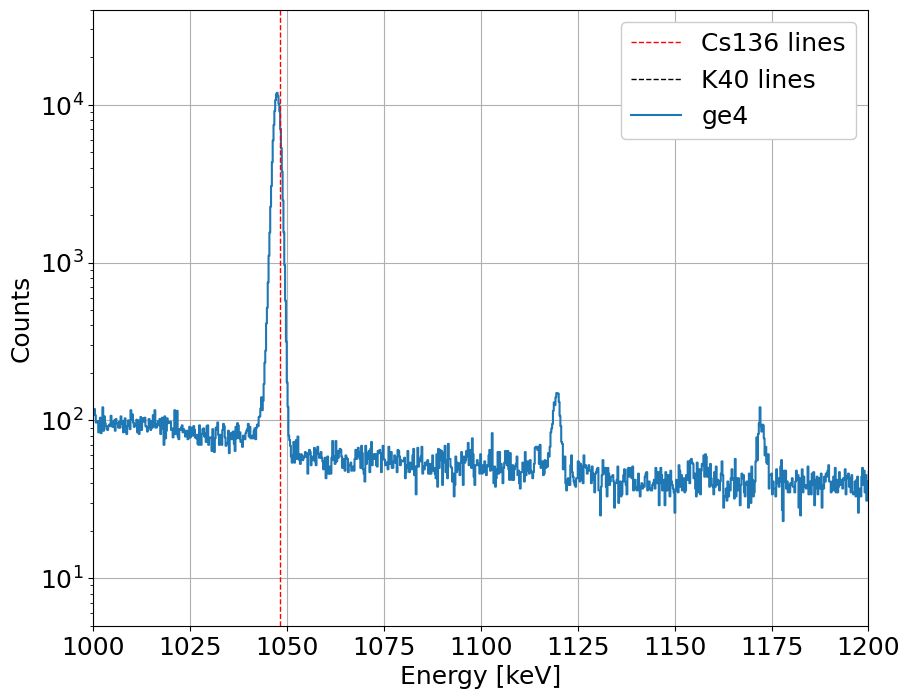

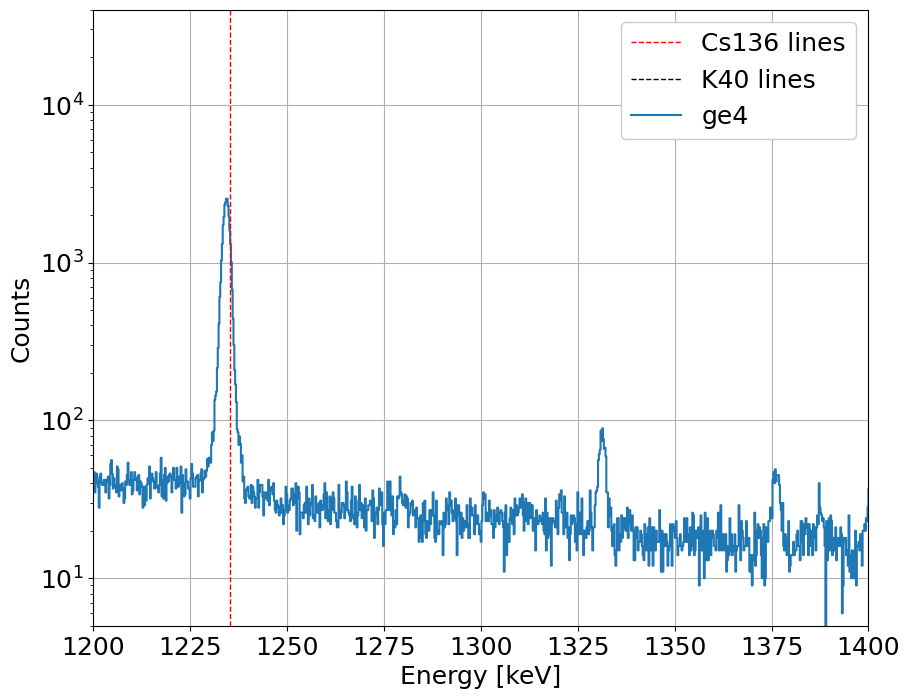

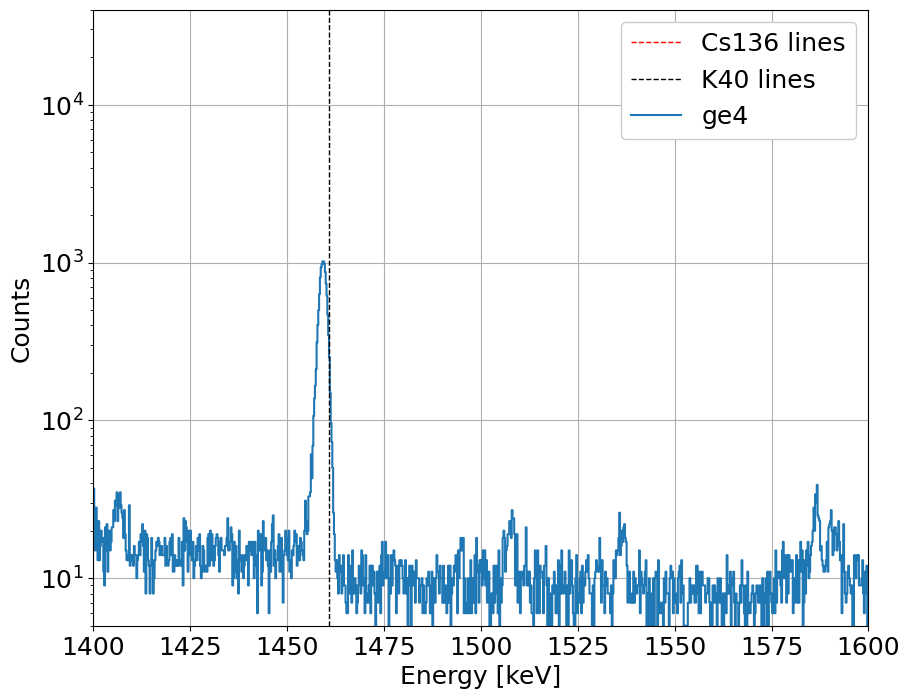

In [73]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 18})

for i in range(8):
    
    plt.figure(i)
    
    xmin = 200.*(i)
    xmax = 200.*(i+1)

    for det, hist in calibrated_hists.items():
        if '4' in det:
            hl.plot1d( hist, label=det )

    ymin = 5.
    ymax = 4e4

    plt.xlabel('Energy [keV]')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)


    for i, line in enumerate(cs136_list):
        if i == 0:
            label = 'Cs136 lines'
        else:
            label = ''

        plt.plot( np.ones(20)*line[0], np.linspace(ymin,ymax,20), \
                 '--r', linewidth=1, label = label)

    for i, line in enumerate(k40_list):
        if i == 0:
            label = 'K40 lines'
        else:
            label = ''

        plt.plot( np.ones(20)*line[0], np.linspace(ymin,ymax,20), \
                 '--k', linewidth=1, label = label)

    plt.legend( framealpha=1 )
    plt.grid()
    plt.savefig('run307_activation_spectrum_{}-{}_keV.png'.format(int(xmin),int(xmax)),\
                dpi=300,bbox_inches='tight')


plt.show()